<div class = "alert alert-block alert-info">
    <center> <h1> BC2: Predict Hotel Booking Cancellations</h1> 
        <h3>Group L</h3></center>

<br>
<center> Ana Isabel da Silva Resende, m20211018 <BR>
Gonçalo Brancas,  m20210760 <BR>
Ricardo Emanuel Ferreira Gomes, m20211028@novaims.unl.pt<BR>

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from math import ceil
from sklearn.linear_model import LassoCV
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier,BaggingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from numpy import loadtxt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [2]:
data = pd.read_csv(r'H2.csv', skipinitialspace=True)
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6.0,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9.0,NaN,0,Transient,76.50,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9.0,NaN,0,Transient,68.00,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9.0,NaN,0,Transient,76.50,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9.0,NaN,0,Transient,76.50,0,1,Canceled,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
79326,0,102,2017,August,35,31,2,5,3,0.0,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
79327,0,34,2017,August,35,31,2,5,2,0.0,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
79328,0,109,2017,August,35,31,2,5,2,0.0,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [3]:
#Creating a copy of the original Dataset
df = data.copy()

# Exploratory Data Analysis

In [4]:
#As we can see, we have 79330 entries and 31 features
df.shape

(79330, 31)

In [5]:
#To count distinct observations over requested axis
df.nunique()

IsCanceled                        2
LeadTime                        453
ArrivalDateYear                   3
ArrivalDateMonth                 12
ArrivalDateWeekNumber            53
ArrivalDateDayOfMonth            31
StaysInWeekendNights             14
StaysInWeekNights                29
Adults                            5
Children                          4
Babies                            5
Meal                              4
Country                         166
MarketSegment                     8
DistributionChannel               5
IsRepeatedGuest                   2
PreviousCancellations            10
PreviousBookingsNotCanceled      73
ReservedRoomType                  8
AssignedRoomType                  9
BookingChanges                   21
DepositType                       3
Agent                           223
Company                         207
DaysInWaitingList               115
CustomerType                      4
ADR                            5405
RequiredCarParkingSpaces    

In [6]:
df['Adults'].value_counts()

2    58255
1    15879
3     4775
0      390
4       31
Name: Adults, dtype: int64

In [7]:
#To get the descriptive statistics of all features in dataset
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IsCanceled,79330,NaN,NaN,NaN,0.41727,0.493111,0,0,0,1,1
LeadTime,79330,NaN,NaN,NaN,109.736,110.949,0,23,74,163,629
ArrivalDateYear,79330,NaN,NaN,NaN,2016.17,0.699181,2015,2016,2016,2017,2017
ArrivalDateMonth,79330,12,August,8983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrivalDateWeekNumber,79330,NaN,NaN,NaN,27.1774,13.3985,1,17,27,38,53
ArrivalDateDayOfMonth,79330,NaN,NaN,NaN,15.7866,8.72845,1,8,16,23,31
StaysInWeekendNights,79330,NaN,NaN,NaN,0.795185,0.885026,0,0,1,2,16
StaysInWeekNights,79330,NaN,NaN,NaN,2.18296,1.45642,0,1,2,3,41
Adults,79330,NaN,NaN,NaN,1.85098,0.509292,0,2,2,2,4
Children,79326,NaN,NaN,NaN,0.0913698,0.372177,0,0,0,0,3


In [8]:
#To check the data types of the columns and to see what other transformations can be done in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment   

In [9]:
print('\033[1mDuplicated values in dataset: ')
df.duplicated().value_counts()

Duplicated values in dataset: 


False    53428
True     25902
dtype: int64

In [10]:
#Calculating the percentage of duplicated values
duplicated_percentage = 25902/(len(df))*100

print("\033[1mPercentage of duplicated values: \033[0m", duplicated_percentage)

Percentage of duplicated values:  32.65095172066053


In [11]:
#Show the duplicate records
df.loc[df.duplicated(keep='first'), :]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
9,1,62,2015,July,27,2,2,3,2,0.0,...,No Deposit,8.0,NaN,0,Transient,76.50,0,1,No-Show,2015-07-02
12,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1.0,NaN,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
17,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1.0,NaN,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
18,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1.0,NaN,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
22,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1.0,NaN,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79289,0,186,2017,August,35,31,0,3,2,0.0,...,No Deposit,9.0,NaN,0,Transient,126.00,0,2,Check-Out,2017-09-03
79292,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9.0,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79293,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9.0,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79294,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9.0,NaN,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03


In [12]:
df.drop_duplicates(keep='last', inplace=True)

As we can see, our dataset contains duplicates. Since we do not have a feature such as "booking ID", we cannot say for sure that those are true duplicates which makes deleting those "duplicates" questionable.
Note: For modeling purposes, models were run with and without the duplicates and greater predictive power was found when the "duplicates" were included. As a result, we will keep the "duplicates".

In [13]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate'],
      dtype='object')

In [14]:
# Define metric, non-metric features and ordinal features
metric_features = ['LeadTime','ArrivalDateWeekNumber', 'ArrivalDateYear', 'ArrivalDateDayOfMonth',
                       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
                       'Babies', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 
                       'BookingChanges', 'DaysInWaitingList', 'ADR',
                       'TotalOfSpecialRequests', 'RequiredCarParkingSpaces']

non_metric_features = df.columns.drop(metric_features).to_list()

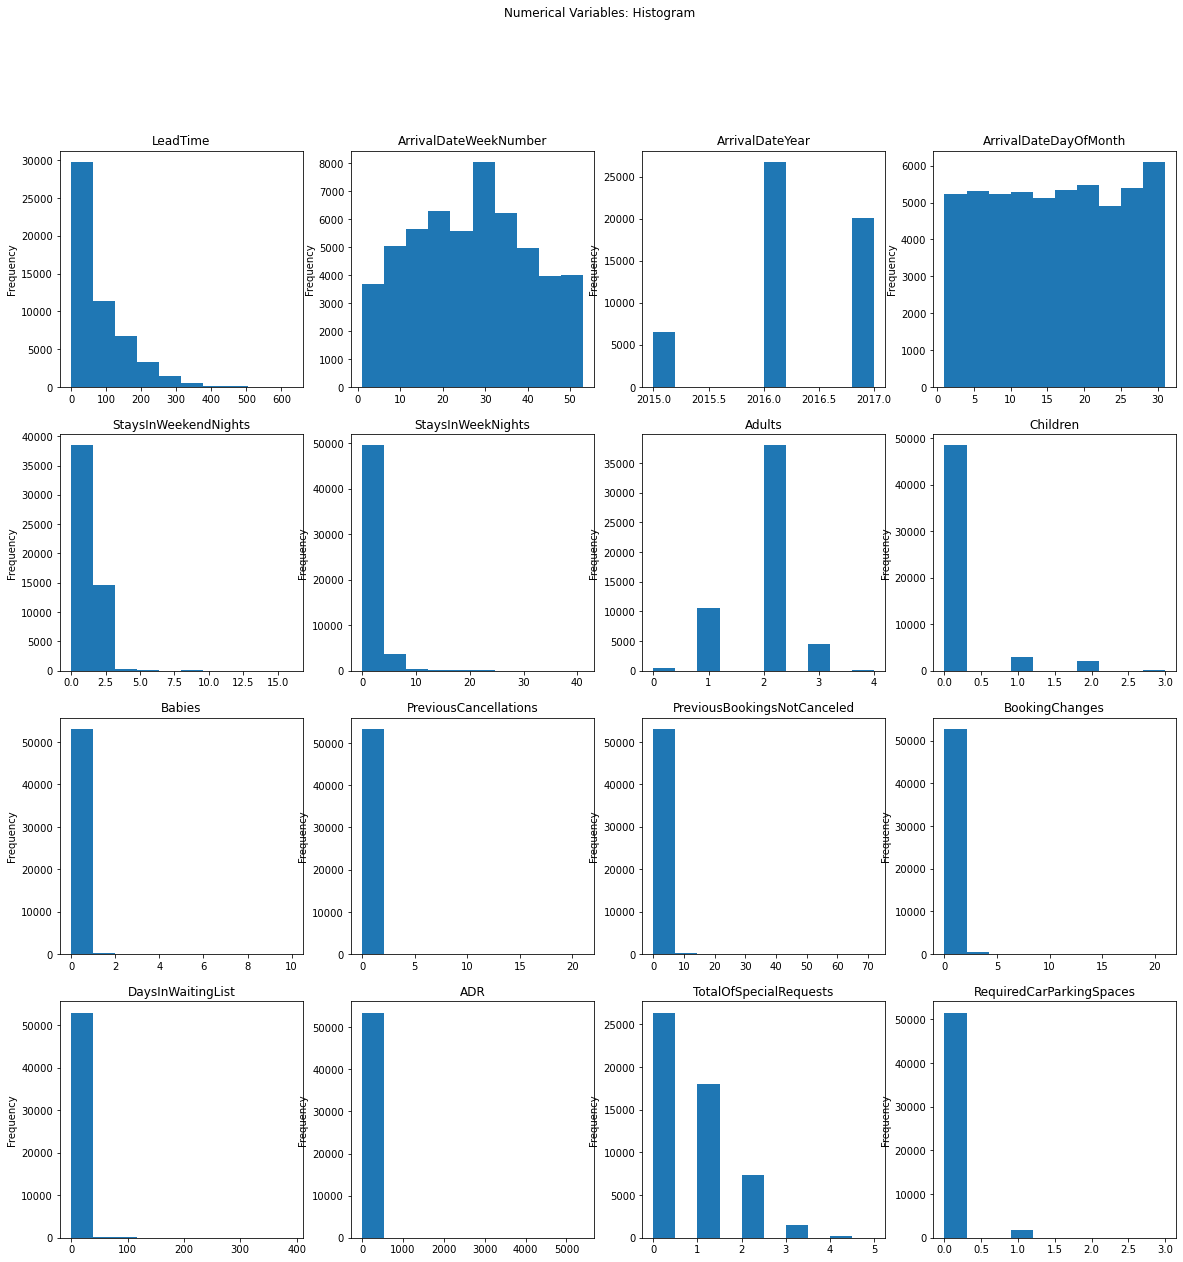

In [15]:
#Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# Plot data
for ax, feat in zip(axes.flatten(), metric_features): 
    df[feat].plot(kind="hist", ax=ax, title=feat, bins=10)

title = "Numerical Variables: Histogram"
plt.suptitle(title)

plt.show()

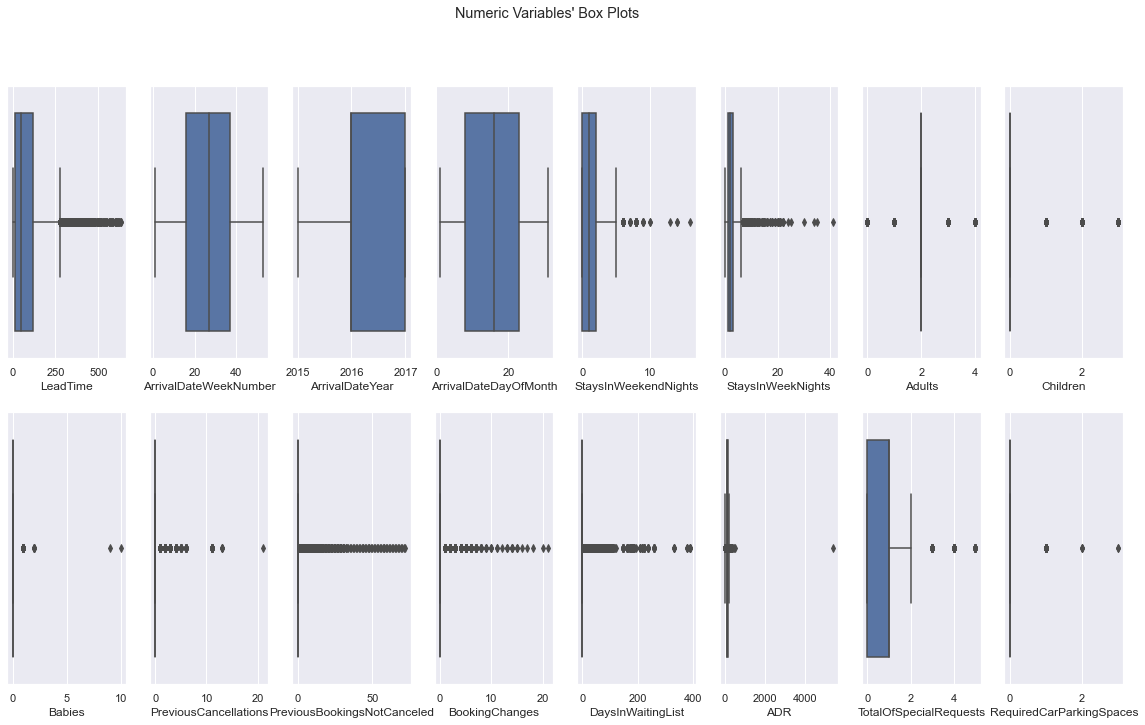

In [16]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)
#plt.savefig(format='jpeg', dpi=400, fname = 'BoxPlots.jpg')
plt.show()

In [17]:
def box_plot_numerical(df, features, title):
    # Prepare figure
    fig, axes = plt.subplots(4, 4, figsize=(20, 20), constrained_layout=True)

    # Plot data
    for ax, f in zip(axes.flatten(), features):
        sns.boxplot(y=f, data=df, ax=ax, x='IsCanceled')
        ax.set_title(f)
        ax.set_ylabel('') 
        
    # Layout
    plt.suptitle(title, fontsize=16)
    plt.show()

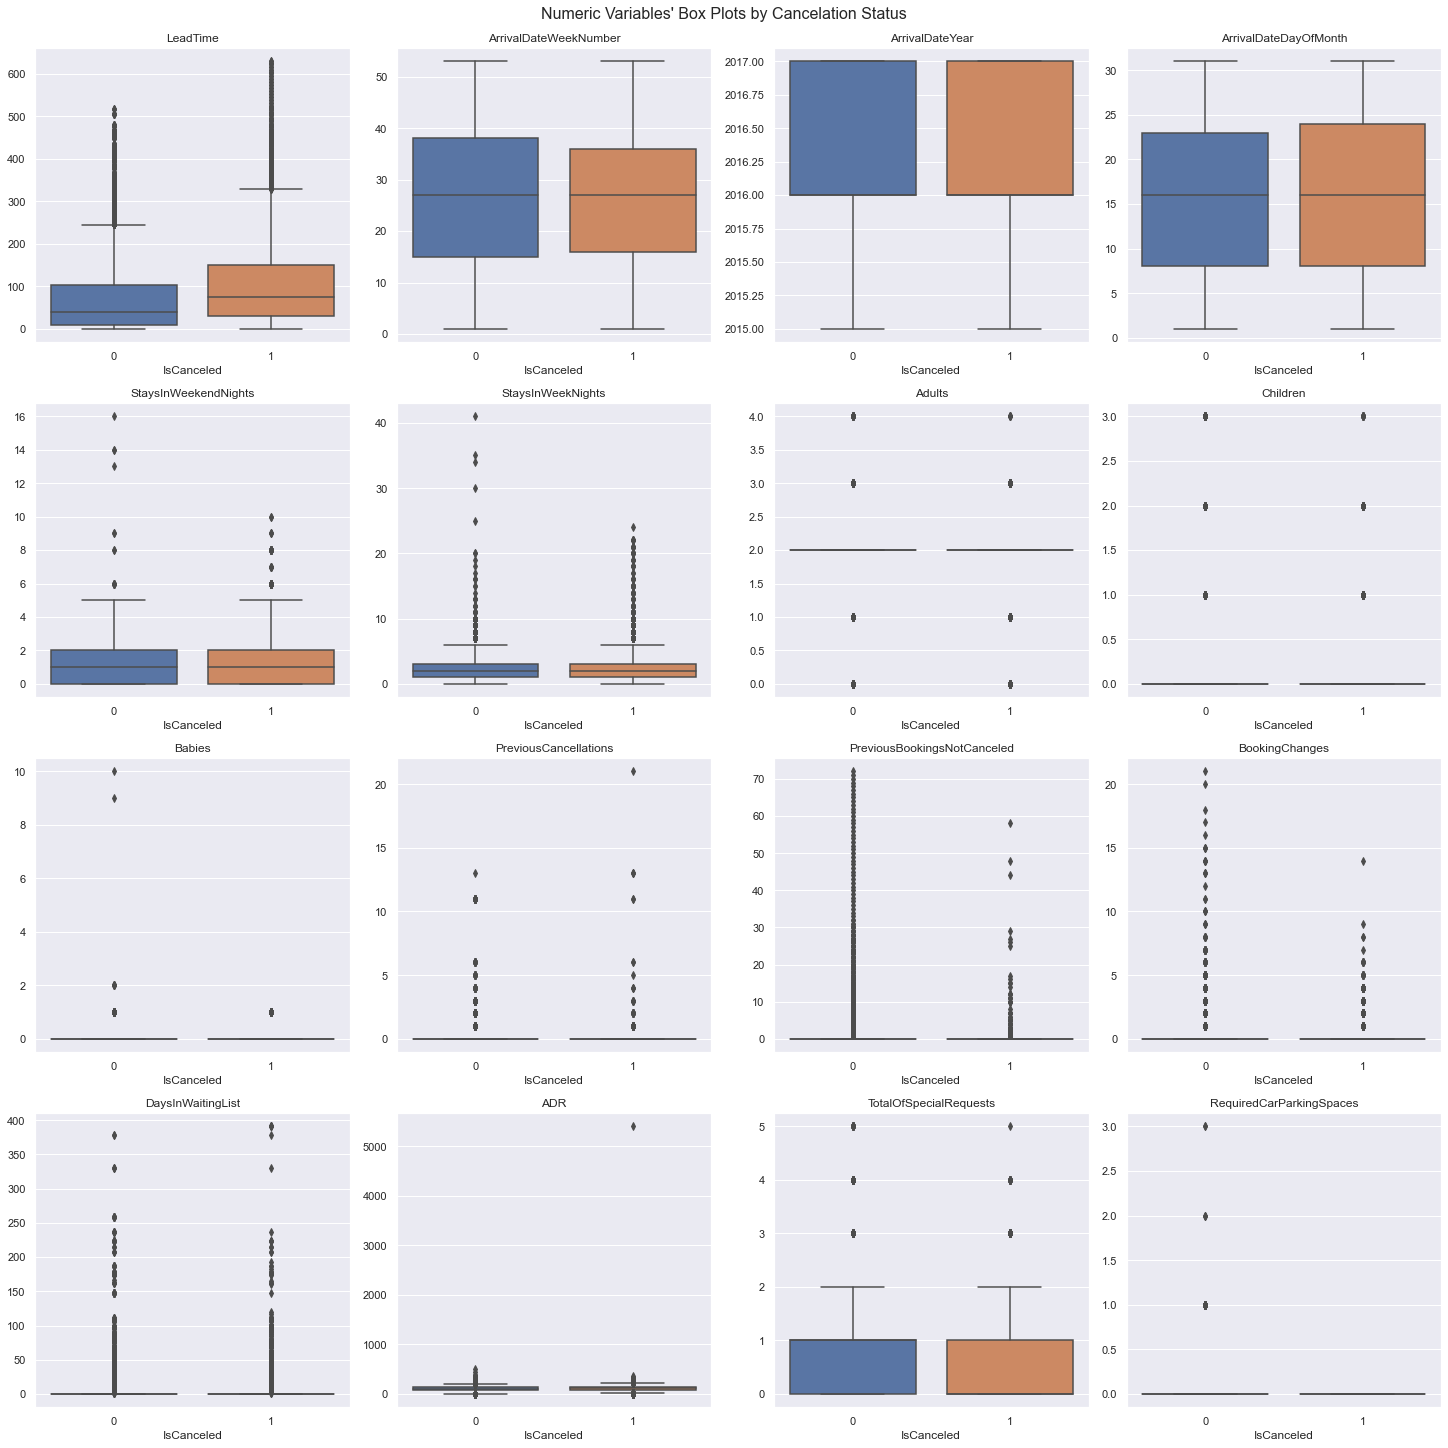

In [18]:
title = "Numeric Variables' Box Plots by Cancelation Status"

# features to plot
plot_features = metric_features

box_plot_numerical(df, plot_features, title)

In [19]:
df.shape

(53428, 31)

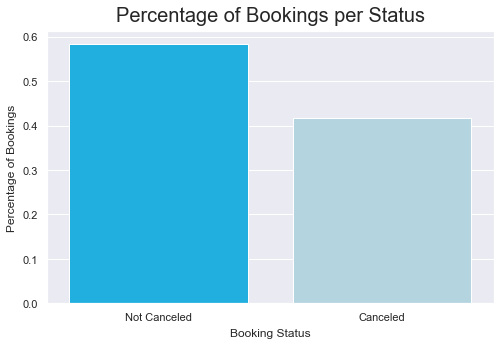

In [20]:
# Visualizing the percentage of canceled vs not canceled bookings: 
plt.figure(figsize=(8,5)) 
plt.title("Percentage of Bookings per Status", fontsize = 20, pad = 10)
sns.barplot(x=data['IsCanceled'].unique(), y=data['IsCanceled'].value_counts(normalize=True), palette=['deepskyblue', 'lightblue'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

# Data Pre-Processing

### Incoherence Checking

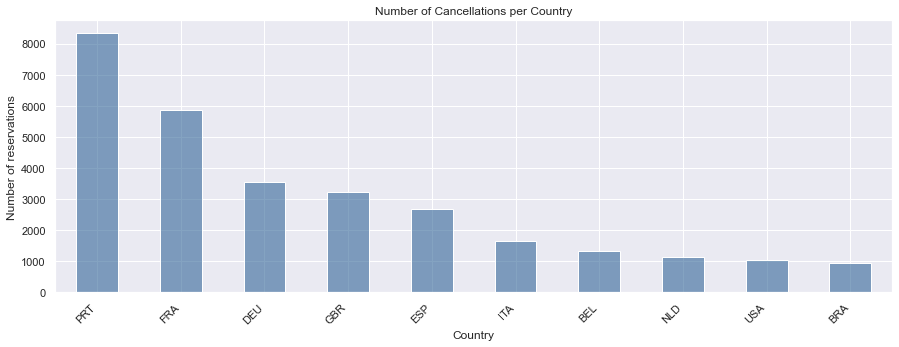

In [21]:
def show_countries_reservations():
    countries = df[df.IsCanceled == 0].groupby('Country').Country.count().sort_values(ascending = False)
    
    plt.figure(figsize = (15, 5))
    ax = countries.head(10).plot(kind = 'bar', color=(0.2, 0.4, 0.6, 0.6))
    ax.set_title('Number of Cancellations per Country')
    ax.set_xlabel('Country')
    ax.set_ylabel('Number of reservations')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
    plt.show()
    
    return 

show_countries_reservations()

Text(0.5, 1.0, 'Cancellation Rate for Top 10 Source Markets')

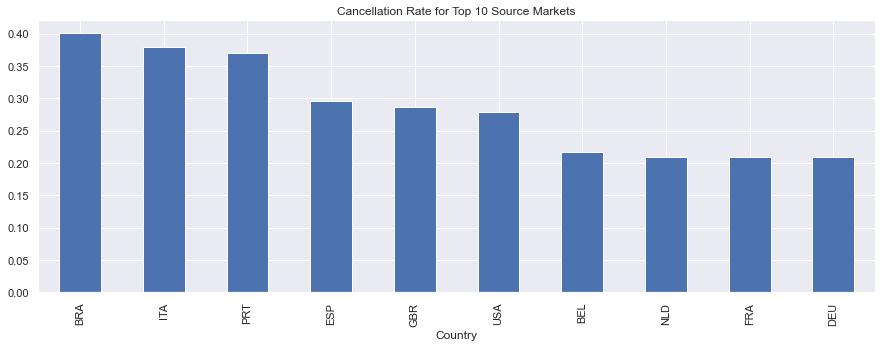

In [22]:
#We will keep Country even if it is not collected correctly it seems to have good prediction power
df.groupby('Country')['IsCanceled'].mean().loc[df['Country'].value_counts()[:10].index.tolist()].sort_values(ascending = False).plot(kind='bar', 
                                                                                                      figsize=(15, 5))
plt.title('Cancellation Rate for Top 10 Source Markets')

<AxesSubplot:xlabel='DepositType'>

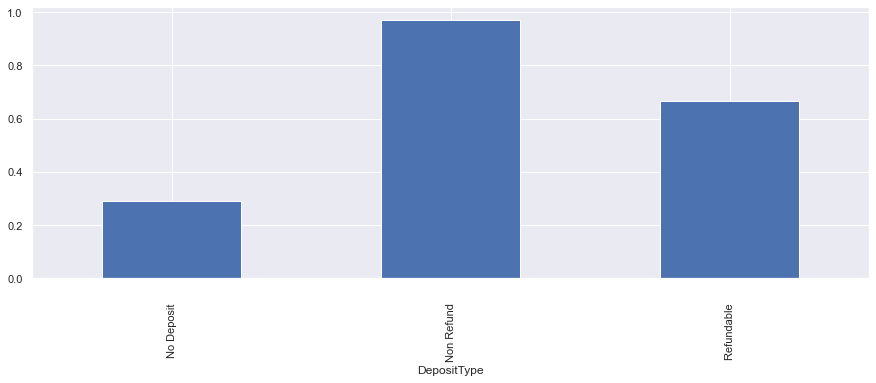

In [23]:
df.groupby('DepositType')['IsCanceled'].mean().plot(kind='bar', figsize=(15, 5))

In [24]:
#DepositType seems to have issues as all rows with 'No-refund' correspond to cancelations
#df.drop(columns='DepositType', inplace=True)

In [25]:
#Checking if there is any rows with both StaysInWeekendNights and StaysInWeekNights equal to 0 (doesn´t make sense)
print(len(df[(df['StaysInWeekendNights']==0) & (df['StaysInWeekNights']==0)]))

288


In [26]:
#Coherence check - deleting the rows thta didn't make sense
df['Stay'] = df.apply(lambda x:0 if (x.StaysInWeekendNights==0 and x.StaysInWeekNights==0) else 1, axis=1)

df.drop(df.loc[df['Stay']==0].index, inplace=True)
del df['Stay']
df

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6.0,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9.0,NaN,0,Transient,76.50,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9.0,NaN,0,Transient,68.00,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9.0,NaN,0,Transient,76.50,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9.0,NaN,0,Transient,76.50,0,1,Canceled,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
79326,0,102,2017,August,35,31,2,5,3,0.0,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
79327,0,34,2017,August,35,31,2,5,2,0.0,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
79328,0,109,2017,August,35,31,2,5,2,0.0,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [27]:
# Convert `ArrivalDateMonth` names to numbers
df['ArrivalDateMonth'].replace({'January' : '1',
        'February' : '2',
        'March' : '3',
        'April' : '4',
        'May' : '5',
        'June' : '6',
        'July' : '7',
        'August' : '8',
        'September' : '9', 
        'October' : '10',
        'November' : '11',
        'December' : '12'}, inplace=True)

Text(0, 0.5, 'ADR')

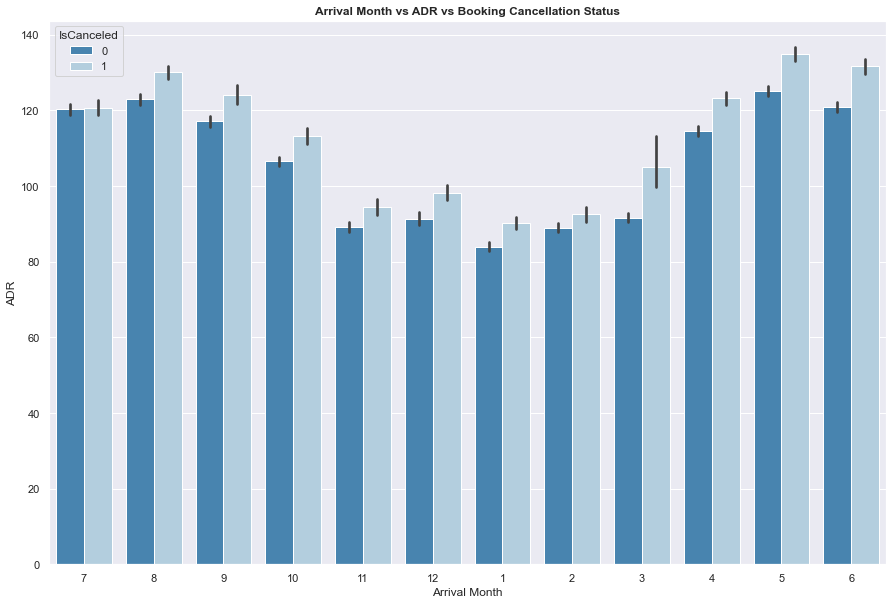

In [28]:
# Display `ADR` vs `Booking Cancellation Status` by month
df['ADR'] = df['ADR'].astype(float)
plt.figure(figsize=(15,10))
sns.barplot(x='ArrivalDateMonth', y='ADR', hue='IsCanceled', dodge=True, palette= 'Blues_r', data=df)
plt.title('Arrival Month vs ADR vs Booking Cancellation Status', weight='bold')
plt.xlabel('Arrival Month', fontsize=12)
plt.ylabel('ADR', fontsize=12)

Text(0, 0.5, 'Count')

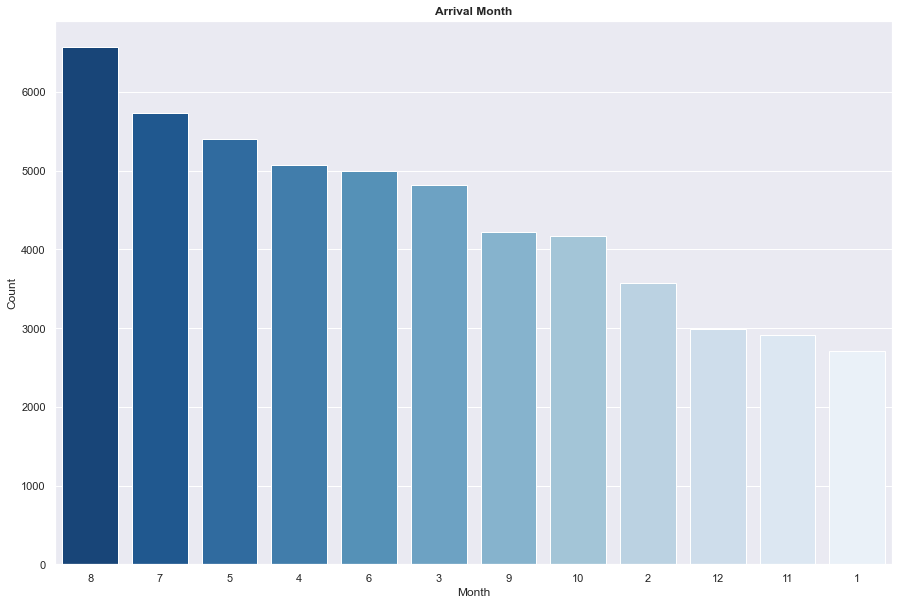

In [29]:
# Display arrival count by month 
plt.figure(figsize=(15,10))
sns.countplot(x='ArrivalDateMonth', data = df,
              order=pd.value_counts(df['ArrivalDateMonth']).index, palette='Blues_r')
plt.title('Arrival Month', weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)

 - Note: August is the busiest month and January is the least occupied month.

Text(0, 0.5, 'Count')

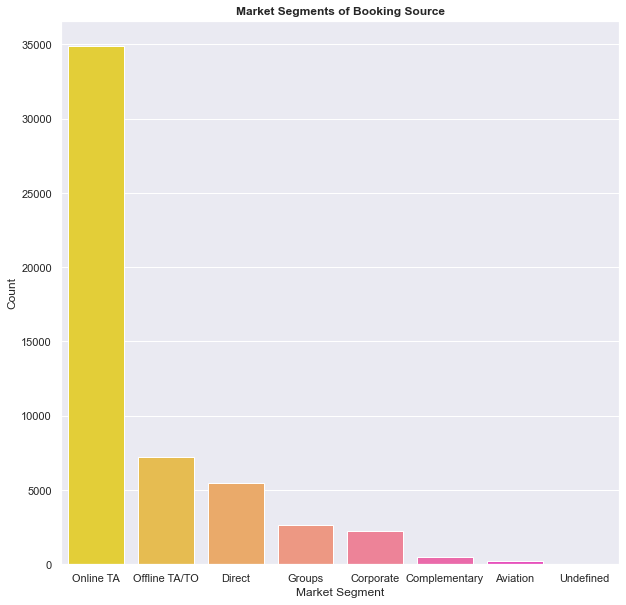

In [30]:
# Exploring `Market_segment` or booking source data
plt.figure(figsize=(10,10))
sns.countplot(df['MarketSegment'], palette='spring_r', 
              order=pd.value_counts(df['MarketSegment']).index)
plt.title('Market Segments of Booking Source', weight='bold')
plt.xlabel('Market Segment', fontsize=12)
plt.ylabel('Count', fontsize=12)

In [31]:
df.drop(index=df[df['MarketSegment']=='Undefined'].index, inplace=True)

In [32]:
df['MarketSegment']=df.MarketSegment.apply(lambda x: 'Agent' if ((x == 'Offline TA/TO') | 
                                                                        (x == 'Online TA')) 
                                               else ('Company' if ((x == 'Corporate') | 
                                                                     (x == 'Aviation')) else 'Direct'))



Text(0, 0.5, 'Bookings')

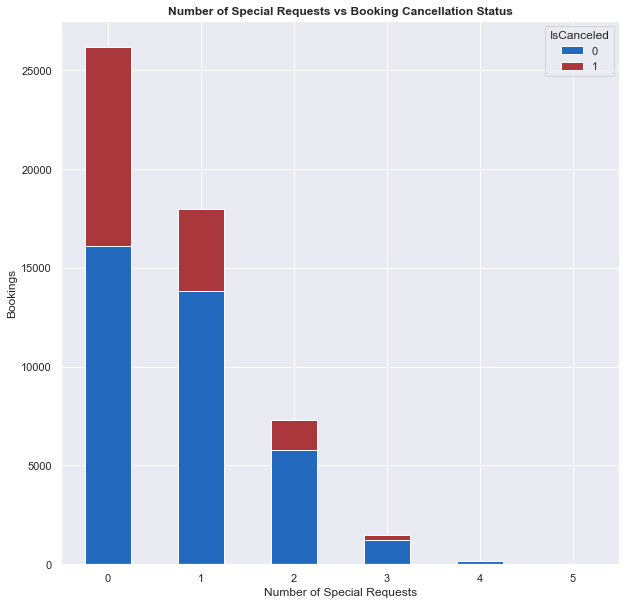

In [33]:
# Use groupby to see if number of special requests affects cancellation status
groupSpecRequest = df.groupby([ 'TotalOfSpecialRequests', 'IsCanceled']).size().unstack(fill_value=0)
groupSpecRequest.plot(kind='bar', stacked=True, cmap='vlag', figsize=(10,10))
plt.title('Number of Special Requests vs Booking Cancellation Status', weight='bold')
plt.xlabel('Number of Special Requests', fontsize=12)
plt.xticks(rotation=360)
plt.ylabel('Bookings', fontsize=12)

#### Close to half of all bookings made with no special requests turned out to be canceled while bookings with more special requests are more averse to be dropped.

In [34]:
#Drop booking with no persons included as these are not room reservations and are not relevant for the model
df['TotalGuests'] = df['Adults'] + df['Children'] + df['Babies']
df.drop(index=df[df['TotalGuests']==0].index, inplace=True)

df.shape

(53041, 32)

### Filling Missing Values 

In [35]:
#Filling with "0" the variable 'Children'
df['Children'] = df['Children'].fillna(0)

#Since it is just a small portion, delete the rows where there are missing values in the Country variable.
df = df.dropna(axis=0, subset=['Country'])

#Creating new variables
df['TotalGuests'] = df['Adults'] + df['Children'] + df['Babies']
df['AllChildren'] = df['Children'] + df['Babies']

In [36]:
#Checking if there are reservations with only babies, because it's "impossible"
len(df.loc[(df['Adults'] ==0) & (df['Children'] == 0) & (df['Babies']!=0)])

0

In [37]:
del df['Children']
del df['Babies']

    - Note: Since there is no information about the minimum age of the clients, and it is a small porportion, the bookings with 0 Adults and with some Children aren't going to be deleted.

In [38]:
df['Agent']= df['Agent'].fillna('999')
df['Company'] = df['Company'].fillna('999')
len(df.loc[(df['Company'] ==999) & (df['Agent'] ==999)])

0

In [39]:
#If both Agent and Company have NULL values, it means that no external help was searched (the customer booked himself)

df['ExternalBooking'] = df.apply(lambda x:0 if (x.Agent==999 and x.Company==999) else 1, axis=1)

In [40]:
df['ExternalBooking'].value_counts() #all customers reached for external booking help

1    53038
Name: ExternalBooking, dtype: int64

In [41]:
#Dropping Company and Agent
#del df['Agent']
del df['Company']
df

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Meal,...,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,TotalGuests,AllChildren,ExternalBooking
0,0,6,2015,7,27,1,0,2,1,HB,...,0,Transient,0.00,0,0,Check-Out,2015-07-03,1.0,0.0,1
1,1,88,2015,7,27,1,0,4,2,BB,...,0,Transient,76.50,0,1,Canceled,2015-07-01,2.0,0.0,1
2,1,65,2015,7,27,1,0,4,1,BB,...,0,Transient,68.00,0,1,Canceled,2015-04-30,1.0,0.0,1
3,1,92,2015,7,27,1,2,4,2,BB,...,0,Transient,76.50,0,2,Canceled,2015-06-23,2.0,0.0,1
4,1,100,2015,7,27,2,0,2,2,BB,...,0,Transient,76.50,0,1,Canceled,2015-04-02,2.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,8,35,30,2,5,2,BB,...,0,Transient,96.14,0,0,Check-Out,2017-09-06,2.0,0.0,1
79326,0,102,2017,8,35,31,2,5,3,BB,...,0,Transient,225.43,0,2,Check-Out,2017-09-07,3.0,0.0,1
79327,0,34,2017,8,35,31,2,5,2,BB,...,0,Transient,157.71,0,4,Check-Out,2017-09-07,2.0,0.0,1
79328,0,109,2017,8,35,31,2,5,2,BB,...,0,Transient,104.40,0,0,Check-Out,2017-09-07,2.0,0.0,1


In [42]:
#Update metric e non metric features

metric_features.remove('Children')
metric_features.remove('Babies')
metric_features.append('TotalGuests')
metric_features.append('AllChildren')

non_metric_features.remove('Company')
#non_metric_features.remove('Agent')
non_metric_features.append('ExternalBooking')

# Outliers Removal

### DBScan

In [43]:
df.shape

(53038, 31)

In [44]:
#Applying StandardScaler before using DBScan to identify outliers
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
metric_features_scaled = scaler.fit_transform(df[metric_features])
data_scaled = pd.DataFrame(metric_features_scaled, 
                           columns=df[metric_features].columns)

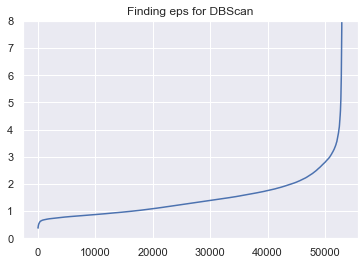

In [45]:
# K-distance graph to find out the right eps value

neigh = NearestNeighbors(n_neighbors=32)
neigh.fit(data_scaled)
distances, _ = neigh.kneighbors(data_scaled)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.ylim(0,8)
plt.title('Finding eps for DBScan')
plt.show()

In [46]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=3, min_samples=32, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(data_scaled)
df['label']=dbscan_labels

In [47]:
#check the % of outliers
round(len(df[df['label']==-1])/len(df), 7)

0.0149138

In [48]:
#Saving Outliers in a separate dataframe
df_outliers = df[df['label']==-1]
df_outliers

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Meal,...,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,TotalGuests,AllChildren,ExternalBooking,label
54,1,90,2015,7,28,7,5,15,1,SC,...,Transient,48.60,0,0,Canceled,2015-04-08,1.0,0.0,1,-1
55,1,90,2015,7,28,7,5,15,1,SC,...,Transient,48.60,0,0,Canceled,2015-04-11,1.0,0.0,1,-1
56,1,117,2015,7,28,7,5,15,1,BB,...,Transient,48.60,0,0,Canceled,2015-04-08,1.0,0.0,1,-1
265,0,20,2015,7,30,22,0,2,2,BB,...,Transient,62.00,0,0,Check-Out,2015-07-24,2.0,0.0,1,-1
537,0,6,2015,8,32,3,1,0,1,BB,...,Transient,75.00,1,1,Check-Out,2015-08-04,3.0,2.0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78853,0,200,2017,8,34,25,0,2,3,BB,...,Transient,294.00,1,0,Check-Out,2017-08-27,5.0,2.0,1,-1
78900,0,97,2017,8,34,21,1,5,2,BB,...,Transient-Party,125.00,0,0,Check-Out,2017-08-27,2.0,0.0,1,-1
79010,0,0,2017,8,35,29,0,1,2,BB,...,Group,270.00,0,1,Check-Out,2017-08-30,5.0,3.0,1,-1
79107,0,232,2017,8,34,26,2,3,2,BB,...,Transient,119.00,0,0,Check-Out,2017-08-31,2.0,0.0,1,-1


In [49]:
#Keep data clean of outliers
df_1 = df[df['label']!=-1]

In [50]:
df_1.drop(columns='label',inplace=True)

In [51]:
df_1.isna().sum().sort_values()

IsCanceled                     0
TotalGuests                    0
ReservationStatusDate          0
ReservationStatus              0
TotalOfSpecialRequests         0
RequiredCarParkingSpaces       0
ADR                            0
CustomerType                   0
DaysInWaitingList              0
Agent                          0
DepositType                    0
BookingChanges                 0
AssignedRoomType               0
ReservedRoomType               0
AllChildren                    0
PreviousBookingsNotCanceled    0
IsRepeatedGuest                0
DistributionChannel            0
MarketSegment                  0
Country                        0
Meal                           0
Adults                         0
StaysInWeekNights              0
StaysInWeekendNights           0
ArrivalDateDayOfMonth          0
ArrivalDateWeekNumber          0
ArrivalDateMonth               0
ArrivalDateYear                0
LeadTime                       0
PreviousCancellations          0
ExternalBo

In [52]:
df_1.shape

(52247, 31)

# Feature Engineering

In [53]:
# Creating the ArrivalDate feature to order the dataset 
df_1['ArrivalDate'] = df_1['ArrivalDateYear'].astype(str) + "-" + df_1['ArrivalDateMonth'].astype(str) + "-" + df_1['ArrivalDateDayOfMonth'].astype(str)
df_1['ArrivalDate'] = pd.to_datetime(df_1['ArrivalDate'], format="%Y-%m-%d")
df_1

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Meal,...,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,TotalGuests,AllChildren,ExternalBooking,ArrivalDate
0,0,6,2015,7,27,1,0,2,1,HB,...,Transient,0.00,0,0,Check-Out,2015-07-03,1.0,0.0,1,2015-07-01
1,1,88,2015,7,27,1,0,4,2,BB,...,Transient,76.50,0,1,Canceled,2015-07-01,2.0,0.0,1,2015-07-01
2,1,65,2015,7,27,1,0,4,1,BB,...,Transient,68.00,0,1,Canceled,2015-04-30,1.0,0.0,1,2015-07-01
3,1,92,2015,7,27,1,2,4,2,BB,...,Transient,76.50,0,2,Canceled,2015-06-23,2.0,0.0,1,2015-07-01
4,1,100,2015,7,27,2,0,2,2,BB,...,Transient,76.50,0,1,Canceled,2015-04-02,2.0,0.0,1,2015-07-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,8,35,30,2,5,2,BB,...,Transient,96.14,0,0,Check-Out,2017-09-06,2.0,0.0,1,2017-08-30
79326,0,102,2017,8,35,31,2,5,3,BB,...,Transient,225.43,0,2,Check-Out,2017-09-07,3.0,0.0,1,2017-08-31
79327,0,34,2017,8,35,31,2,5,2,BB,...,Transient,157.71,0,4,Check-Out,2017-09-07,2.0,0.0,1,2017-08-31
79328,0,109,2017,8,35,31,2,5,2,BB,...,Transient,104.40,0,0,Check-Out,2017-09-07,2.0,0.0,1,2017-08-31


In [54]:
len(df_1.loc[(df_1['ReservationStatus'] == 'Canceled') & (df_1['ArrivalDate'] != 0)])

15094

In [55]:
len(df_1.loc[(df_1['ReservationStatus'] == 'No-Show') & (df_1['ArrivalDate'] != 0)])

720

In [56]:
df_1['ReservationStatus'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

In [57]:
(len(df_1.loc[(df_1['ReservationStatus'] == 'Canceled') & (df_1['ArrivalDate'] != 0)]) + len(df_1.loc[(df_1['ReservationStatus'] == 'No-Show') & (df_1['ArrivalDate'] != 0)])) / len(df_1) * 100

30.267766570329396

In [58]:
# Created a dataframe of canceled bookings for plotting purposes
canceled = df_1[df_1['IsCanceled']==1][['ArrivalDate']]
canceled.set_index('ArrivalDate', inplace=True)
canceled['count'] = 1
canceled=canceled.resample('M').sum()

# Created a dataframe of not canceled bookings for plotting purposes
not_canceled = df_1[df_1['IsCanceled']==0][['ArrivalDate']]
not_canceled.set_index('ArrivalDate', inplace=True)
not_canceled['count'] = 1
not_canceled=not_canceled.resample('M').sum()

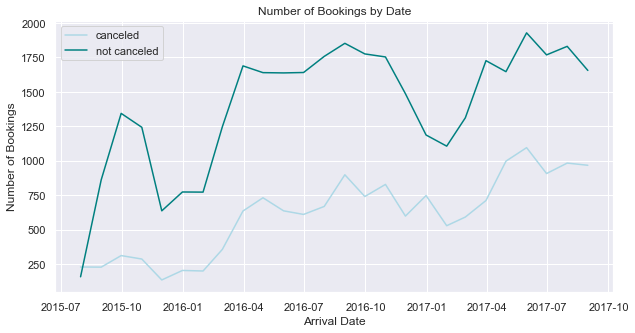

In [59]:
# Visualizing the number of canceled and not canceled bookings by date:
plt.figure(figsize=(10,5))
sns.lineplot(x=canceled.index, y=canceled['count'], color='lightblue')
sns.lineplot(x=not_canceled.index, y=not_canceled['count'], color='teal')
plt.ylabel('Number of Bookings')
plt.xlabel('Arrival Date')
plt.title('Number of Bookings by Date')
plt.legend(['canceled', 'not canceled']);

In [60]:
df_1['ReservationStatusDate'] = pd.to_datetime(df_1['ReservationStatusDate'], format="%Y-%m-%d")

In [61]:
#Change Categorical to Numerical Variable
df_1['ReservationStatusYear']=df_1.ReservationStatusDate.dt.year
df_1['ReservationStatusMonth']=df_1.ReservationStatusDate.dt.month
df_1['ReservationStatusDay']=df_1.ReservationStatusDate.dt.day

In [62]:
#Ordering the records by the ArrivalDate
df_1 = df_1.sort_values(['ArrivalDate'])
df_1

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Meal,...,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,TotalGuests,AllChildren,ExternalBooking,ArrivalDate,ReservationStatusYear,ReservationStatusMonth,ReservationStatusDay
0,0,6,2015,7,27,1,0,2,1,HB,...,0,Check-Out,2015-07-03,1.0,0.0,1,2015-07-01,2015,7,3
35547,0,257,2015,7,27,1,0,2,2,HB,...,0,Check-Out,2015-07-03,2.0,0.0,1,2015-07-01,2015,7,3
35546,0,257,2015,7,27,1,0,2,2,HB,...,0,Check-Out,2015-07-03,2.0,0.0,1,2015-07-01,2015,7,3
35499,0,257,2015,7,27,1,0,2,1,HB,...,0,Check-Out,2015-07-03,1.0,0.0,1,2015-07-01,2015,7,3
34941,1,181,2015,7,27,1,0,2,2,BB,...,3,Canceled,2015-06-17,2.0,0.0,1,2015-07-01,2015,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79272,0,27,2017,8,35,31,0,3,2,BB,...,1,Check-Out,2017-09-03,2.0,0.0,1,2017-08-31,2017,9,3
79271,0,104,2017,8,35,31,0,3,1,BB,...,0,Check-Out,2017-09-03,1.0,0.0,1,2017-08-31,2017,9,3
33634,1,177,2017,8,35,31,0,3,2,BB,...,1,Canceled,2017-07-26,2.0,0.0,1,2017-08-31,2017,7,26
33640,1,222,2017,8,35,31,0,3,2,BB,...,3,Canceled,2017-05-05,2.0,0.0,1,2017-08-31,2017,5,5


In [63]:
df_1.reset_index(drop=True,inplace=True) #dropping the previous index

In [64]:
#These variables are dates, and for that reason won't be used for model proposes
df_1 = df_1.drop(columns=['ArrivalDate', 'ReservationStatusDate'])
df_1

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Meal,...,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,TotalGuests,AllChildren,ExternalBooking,ReservationStatusYear,ReservationStatusMonth,ReservationStatusDay
0,0,6,2015,7,27,1,0,2,1,HB,...,0.00,0,0,Check-Out,1.0,0.0,1,2015,7,3
1,0,257,2015,7,27,1,0,2,2,HB,...,101.50,0,0,Check-Out,2.0,0.0,1,2015,7,3
2,0,257,2015,7,27,1,0,2,2,HB,...,101.50,0,0,Check-Out,2.0,0.0,1,2015,7,3
3,0,257,2015,7,27,1,0,2,1,HB,...,80.00,0,0,Check-Out,1.0,0.0,1,2015,7,3
4,1,181,2015,7,27,1,0,2,2,BB,...,76.50,0,3,Canceled,2.0,0.0,1,2015,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52242,0,27,2017,8,35,31,0,3,2,BB,...,152.67,0,1,Check-Out,2.0,0.0,1,2017,9,3
52243,0,104,2017,8,35,31,0,3,1,BB,...,129.33,0,0,Check-Out,1.0,0.0,1,2017,9,3
52244,1,177,2017,8,35,31,0,3,2,BB,...,95.10,0,1,Canceled,2.0,0.0,1,2017,7,26
52245,1,222,2017,8,35,31,0,3,2,BB,...,117.00,0,3,Canceled,2.0,0.0,1,2017,5,5


In [65]:
#Adding variables for stay duration and total revenue
df_1['TotalOfNights'] = df_1['StaysInWeekendNights'] + df_1['StaysInWeekNights']

df_1['TotalRevenue'] = df_1['ADR']*df_1['TotalOfNights']

In [66]:
# Redefine metric, non-metric features
metric_features.append('TotalOfNights')
metric_features.append('TotalRevenue')
metric_features.append('ReservationStatusYear')
metric_features.append('ReservationStatusMonth')
metric_features.append('ReservationStatusDay')

In [67]:
df_1


,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Meal,...,TotalOfSpecialRequests,ReservationStatus,TotalGuests,AllChildren,ExternalBooking,ReservationStatusYear,ReservationStatusMonth,ReservationStatusDay,TotalOfNights,TotalRevenue
0,0,6,2015,7,27,1,0,2,1,HB,...,0,Check-Out,1.0,0.0,1,2015,7,3,2,0.00
1,0,257,2015,7,27,1,0,2,2,HB,...,0,Check-Out,2.0,0.0,1,2015,7,3,2,203.00
2,0,257,2015,7,27,1,0,2,2,HB,...,0,Check-Out,2.0,0.0,1,2015,7,3,2,203.00
3,0,257,2015,7,27,1,0,2,1,HB,...,0,Check-Out,1.0,0.0,1,2015,7,3,2,160.00
4,1,181,2015,7,27,1,0,2,2,BB,...,3,Canceled,2.0,0.0,1,2015,6,17,2,153.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52242,0,27,2017,8,35,31,0,3,2,BB,...,1,Check-Out,2.0,0.0,1,2017,9,3,3,458.01
52243,0,104,2017,8,35,31,0,3,1,BB,...,0,Check-Out,1.0,0.0,1,2017,9,3,3,387.99
52244,1,177,2017,8,35,31,0,3,2,BB,...,1,Canceled,2.0,0.0,1,2017,7,26,3,285.30
52245,1,222,2017,8,35,31,0,3,2,BB,...,3,Canceled,2.0,0.0,1,2017,5,5,3,351.00


In [68]:
non_metric_features.remove('IsCanceled')
non_metric_features.remove('ReservationStatusDate')

# Data Partition

In [69]:
df_1['Agent'] = df_1['Agent'].astype('int')

### Label Encoding

In [70]:
#Encoding variables
df_encoded = df_1.copy()

df_encoded[non_metric_features] = df_encoded[non_metric_features].apply(LabelEncoder().fit_transform)

### Scaling and Spliting data

In [71]:
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_encoded[metric_features])
scaled_feat

array([[0.00953895, 0.5       , 0.        , ..., 0.33333333, 0.54545455,
        0.06666667],
       [0.40858506, 0.5       , 0.        , ..., 0.33333333, 0.54545455,
        0.06666667],
       [0.40858506, 0.5       , 0.        , ..., 0.33333333, 0.54545455,
        0.06666667],
       ...,
       [0.28139905, 0.65384615, 1.        , ..., 1.        , 0.54545455,
        0.83333333],
       [0.35294118, 0.65384615, 1.        , ..., 1.        , 0.36363636,
        0.13333333],
       [0.00476948, 0.65384615, 1.        , ..., 1.        , 0.72727273,
        0.        ]])

In [72]:
df_encoded[metric_features] = scaled_feat
df_encoded.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Meal,...,TotalOfSpecialRequests,ReservationStatus,TotalGuests,AllChildren,ExternalBooking,ReservationStatusYear,ReservationStatusMonth,ReservationStatusDay,TotalOfNights,TotalRevenue
0,0,0.009539,0.0,9,0.5,0.0,0.0,0.142857,0.25,2,...,0.0,1,0.00,0.0,0,0.333333,0.545455,0.066667,0.052632,0.000000
1,0,0.408585,0.0,9,0.5,0.0,0.0,0.142857,0.50,2,...,0.0,1,0.25,0.0,0,0.333333,0.545455,0.066667,0.052632,0.054526
2,0,0.408585,0.0,9,0.5,0.0,0.0,0.142857,0.50,2,...,0.0,1,0.25,0.0,0,0.333333,0.545455,0.066667,0.052632,0.054526
3,0,0.408585,0.0,9,0.5,0.0,0.0,0.142857,0.25,2,...,0.0,1,0.00,0.0,0,0.333333,0.545455,0.066667,0.052632,0.042976
4,1,0.287758,0.0,9,0.5,0.0,0.0,0.142857,0.50,0,...,0.6,0,0.25,0.0,0,0.333333,0.454545,0.533333,0.052632,0.041096


In [73]:
y = df_encoded['IsCanceled']

X = df_encoded.drop(columns=['IsCanceled'])

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15, stratify=y, test_size=0.3)

# Feature Selection

### Phik Correlation

interval columns not set, guessing: ['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType', 'BookingChanges', 'DepositType', 'Agent', 'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests', 'ReservationStatus', 'TotalGuests', 'AllChildren', 'ExternalBooking', 'ReservationStatusYear', 'ReservationStatusMonth', 'ReservationStatusDay', 'TotalOfNights', 'TotalRevenue']


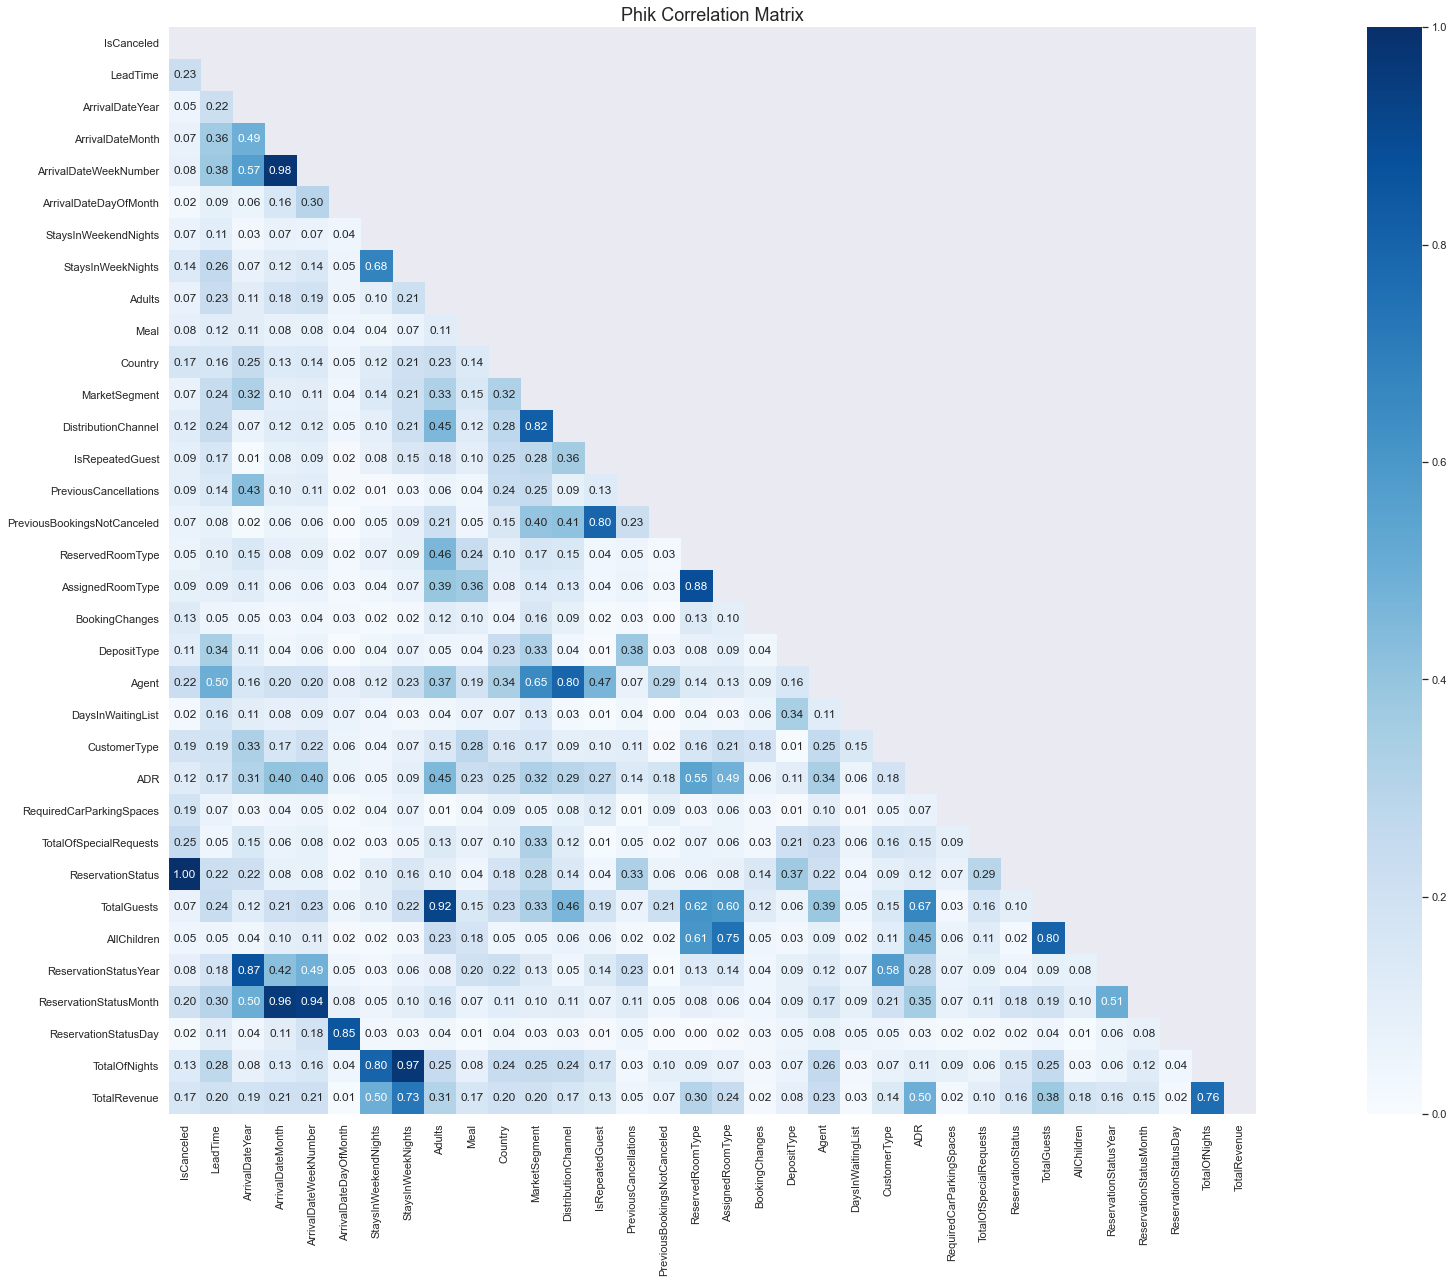

In [75]:
import phik
phik_matrix = df_encoded.phik_matrix()
fig, axes = plt.subplots(1, 1, figsize=(40, 20))

mask = np.zeros_like(phik_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(phik_matrix ,vmin=0, vmax=1, square=True, annot=True, mask=mask,cmap='Blues', fmt='.2f')

plt.title('Phik Correlation Matrix', fontsize=18)
plt.show()

In [76]:
# Create table displaying `ReservationStatus` vs `IsCanceled`
pd.crosstab(columns = df_1['ReservationStatus'], index = df_1['IsCanceled'],
           margins=True, margins_name = 'Total')

ReservationStatus,Canceled,Check-Out,No-Show,Total
IsCanceled,,,,
0,0,36433,0,36433
1,15094,0,720,15814
Total,15094,36433,720,52247


**Drop**
- ArrivalDateWeekNumber
- DistribuitionChannel
- PreviousBookingsNotCanceled
- ReservedRoomType
- ReservationStatus
- ArrivalDateMonth/ReservationStatusDateMonth
- ArrivalDateDay/ReservationStatusDateDay
- TotalOfNights

As we can see, the variable "ReservationStatus" has an high correlation with hotel booking cancellation. So, to avoid overtfitting, we decided to drop "ReservationStatus".

### Feature Selection for Non-metric Data - Chi-Square Test

In [77]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [78]:
for var in X[non_metric_features]:
    TestIndependence(X[var],y_train, var)

ArrivalDateMonth is IMPORTANT for Prediction
Meal is IMPORTANT for Prediction
Country is IMPORTANT for Prediction
MarketSegment is IMPORTANT for Prediction
DistributionChannel is IMPORTANT for Prediction
IsRepeatedGuest is IMPORTANT for Prediction
ReservedRoomType is IMPORTANT for Prediction
AssignedRoomType is IMPORTANT for Prediction
DepositType is IMPORTANT for Prediction
Agent is IMPORTANT for Prediction
CustomerType is IMPORTANT for Prediction
ReservationStatus is IMPORTANT for Prediction
ExternalBooking is NOT an important predictor. (Discard ExternalBooking from model)


**Drop**
- ExternalBooking

### Feature Selection for Metric_Features - Lasso

Lasso picked 20 variables and eliminated the other 1 variables


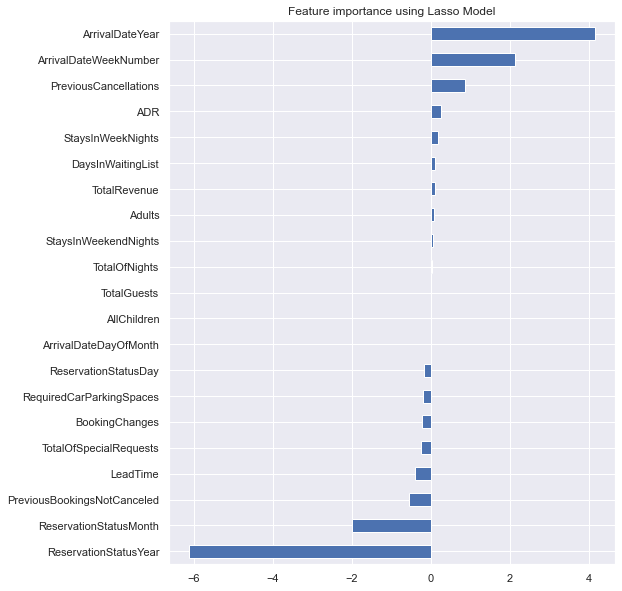

In [79]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()

reg.fit(X[metric_features], y)

coef = pd.Series(reg.coef_, index = X[metric_features].columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

plot_importance(coef,'Lasso')

### Decision Tree

In [80]:
gini_importance = DecisionTreeClassifier().fit(X[metric_features], y).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X[metric_features], y).feature_importances_

<AxesSubplot:xlabel='Value', ylabel='Col'>

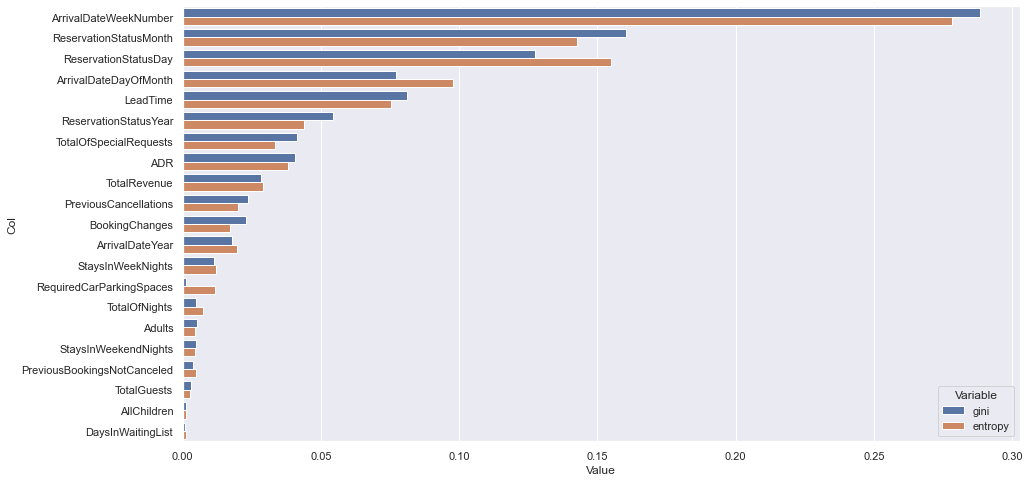

In [81]:
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = X[metric_features].columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [82]:
#Escolhidas
selected_features = ['LeadTime',
'ArrivalDateWeekNumber', 
'TotalOfNights',
'AllChildren',
'PreviousCancellations', 
'PreviousBookingsNotCanceled',
'BookingChanges',
'TotalOfSpecialRequests',
'MarketSegment',
'IsRepeatedGuest',
'ReservedRoomType',
'DepositType',
'CustomerType',
'Agent',
'Country']

interval columns not set, guessing: ['LeadTime', 'ArrivalDateWeekNumber', 'TotalOfNights', 'AllChildren', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'TotalOfSpecialRequests', 'MarketSegment', 'IsRepeatedGuest', 'ReservedRoomType', 'DepositType', 'CustomerType', 'Agent', 'Country']


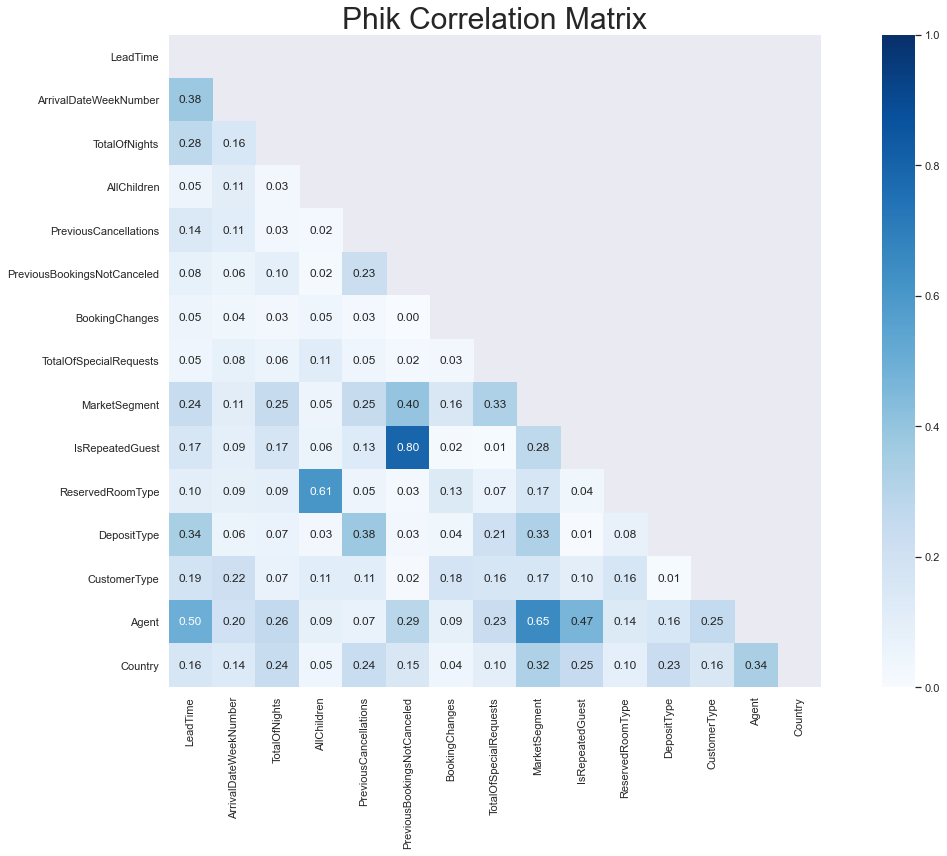

In [83]:
import phik
phik_matrix = df_encoded[selected_features].phik_matrix()
fig, axes = plt.subplots(1, 1, figsize=(22, 12))

mask = np.zeros_like(phik_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(phik_matrix ,vmin=0, vmax=1, square=True, annot=True, mask=mask,cmap='Blues', fmt='.2f')

plt.title('Phik Correlation Matrix', fontsize=30)
plt.savefig(format='jpeg', dpi=400, fname = 'Phik_Selected_Features.jpg')
plt.show()

In [84]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score

In [85]:
def metrics(model, X_train, y_train , X_val, y_val):
    print('_____________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_train,model.predict(X_train))))
    print('Classification Report:\n{}\n'.format(classification_report(y_train, model.predict(X_train))))
    print('Confusion Matrix:\n{}\n'.format(confusion_matrix(y_train, model.predict(X_train))))


    print('_____________________________________')
    print('                                                TEST                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_val,model.predict(X_val))))
    print('Classification Report:\n{}\n'.format(classification_report(y_val, model.predict(X_val))))
    print('Confusion Matrix:\n{}\n'.format(confusion_matrix(y_val, model.predict(X_val))))

In [86]:
len(selected_features)

15

## Splitting data

In [87]:
X = df_encoded[selected_features]
y = df_encoded['IsCanceled']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15, stratify=y, test_size=0.3)

# Modeling

### Decision Trees

In [89]:
dt_params = {
    'max_depth':[None],
    'max_features' : [0.7],
    'min_samples_split': [25], 
    'min_samples_leaf': [1]
}

gsearch = GridSearchCV(DecisionTreeClassifier(random_state=15), 
                       cv=5, 
                       param_grid=dt_params, 
                       scoring = 'f1')
dt = gsearch.fit(X_train, y_train)

In [90]:
metrics(dt, X_train, y_train , X_test, y_test)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.8662

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     25502
           1       0.81      0.73      0.77     11070

    accuracy                           0.87     36572
   macro avg       0.85      0.83      0.84     36572
weighted avg       0.86      0.87      0.86     36572


Confusion Matrix:
[[23580  1922]
 [ 2971  8099]]

_____________________________________
                                                TEST                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.7786

Classification Report:
              precision   

### Random Forest

In [91]:
rf_params = {'bootstrap': [False], 
             'class_weight': ['balanced'], 
             'criterion': ['gini'], 
             'max_depth': [8], 
             'max_features': ['sqrt'], 
             'n_estimators': [950]}

gsearch = GridSearchCV(RandomForestClassifier(random_state=15), 
                       cv=5, 
                       param_grid=dt_params, 
                       scoring = 'f1')
rf = gsearch.fit(X_train, y_train)

In [92]:
metrics(rf, X_train, y_train , X_test, y_test)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.8761

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     25502
           1       0.84      0.73      0.78     11070

    accuracy                           0.88     36572
   macro avg       0.87      0.83      0.85     36572
weighted avg       0.87      0.88      0.87     36572


Confusion Matrix:
[[23999  1503]
 [ 3028  8042]]

_____________________________________
                                                TEST                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.8185

Classification Report:
              precision   

### Bagging Classifier


In [93]:
# Construct Grid Parameters
bc_params = {
    'n_estimators': [45], 
    'max_features': [0.8],
    'bootstrap': [False]
}
gsearch = GridSearchCV(BaggingClassifier(random_state=15), 
                       cv=5, 
                       param_grid=bc_params, 
                       scoring = 'f1')
bc = gsearch.fit(X_train, y_train)

In [94]:
metrics(bc, X_train, y_train , X_test, y_test)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.9934

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     25502
           1       0.99      0.98      0.99     11070

    accuracy                           0.99     36572
   macro avg       0.99      0.99      0.99     36572
weighted avg       0.99      0.99      0.99     36572


Confusion Matrix:
[[25446    56]
 [  187 10883]]

_____________________________________
                                                TEST                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.8021

Classification Report:
              precision   

### Gradient Boosting

In [95]:
# Construct Grid Parameters
gb_params = {'learning_rate':[0.8], 'n_estimators': [500],
                                    'subsample': [1.0], 'max_features': [None]}

gsearch = GridSearchCV(GradientBoostingClassifier(random_state=15), 
                       cv=5, 
                       param_grid=gb_params, 
                       scoring = 'f1')
gb = gsearch.fit(X_train, y_train)

In [96]:
metrics(gb, X_train, y_train , X_test, y_test)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.8602

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     25502
           1       0.80      0.71      0.76     11070

    accuracy                           0.86     36572
   macro avg       0.84      0.82      0.83     36572
weighted avg       0.86      0.86      0.86     36572


Confusion Matrix:
[[23576  1926]
 [ 3187  7883]]

_____________________________________
                                                TEST                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.8038

Classification Report:
              precision   

### XGBoost

In [97]:
# Construct Grid Parameters
xgb_params = {'colsample_bytree': [1.0], 'gamma': [1], 'max_depth': [5], 'min_child_weight': [1],
              'subsample': [0.8]}


# Perform Grid Search
xgb_gs = GridSearchCV(XGBClassifier(random_state = 15),
                 xgb_params,
                 cv = 5,
                 scoring = 'f1')
xgb = xgb_gs.fit(X_train, y_train)

print('Best parameters set found:',xgb.best_params_)
print('Score with best parameters:',xgb.best_score_)

[14:09:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:09:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

In [98]:
metrics(xgb, X_train, y_train , X_test, y_test)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.8358

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     25502
           1       0.77      0.65      0.71     11070

    accuracy                           0.84     36572
   macro avg       0.81      0.78      0.80     36572
weighted avg       0.83      0.84      0.83     36572


Confusion Matrix:
[[23366  2136]
 [ 3870  7200]]

_____________________________________
                                                TEST                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.8159

Classification Report:
              precision   

### CatBoost

In [99]:
#GRIDSEARCH FOR CATBOOST
cb_params = {}

cb_clf = CatBoostClassifier(random_state=15)
cb_cv = GridSearchCV(estimator=cb_clf, 
                          cv = 5, 
                          param_grid=cb_params, 
                          scoring='f1', 
                          n_jobs=-1) 
cb = cb_cv.fit(X_train,y_train)

Learning rate set to 0.043553
0:	learn: 0.6678017	total: 67.4ms	remaining: 1m 7s
1:	learn: 0.6474471	total: 76.8ms	remaining: 38.3s
2:	learn: 0.6294254	total: 86.2ms	remaining: 28.6s
3:	learn: 0.6124196	total: 94.9ms	remaining: 23.6s
4:	learn: 0.6000751	total: 103ms	remaining: 20.6s
5:	learn: 0.5843860	total: 111ms	remaining: 18.4s
6:	learn: 0.5709248	total: 118ms	remaining: 16.7s
7:	learn: 0.5610415	total: 126ms	remaining: 15.6s
8:	learn: 0.5525123	total: 134ms	remaining: 14.8s
9:	learn: 0.5430103	total: 141ms	remaining: 14s
10:	learn: 0.5342221	total: 150ms	remaining: 13.5s
11:	learn: 0.5260239	total: 158ms	remaining: 13s
12:	learn: 0.5180886	total: 165ms	remaining: 12.6s
13:	learn: 0.5125188	total: 173ms	remaining: 12.2s
14:	learn: 0.5072188	total: 180ms	remaining: 11.8s
15:	learn: 0.5020168	total: 188ms	remaining: 11.6s
16:	learn: 0.4961903	total: 196ms	remaining: 11.3s
17:	learn: 0.4921939	total: 204ms	remaining: 11.1s
18:	learn: 0.4897158	total: 212ms	remaining: 10.9s
19:	learn: 

Learning rate set to 0.043553
0:	learn: 0.6733794	total: 67.3ms	remaining: 1m 7s
1:	learn: 0.6514299	total: 77.3ms	remaining: 38.6s
2:	learn: 0.6312433	total: 86.1ms	remaining: 28.6s
3:	learn: 0.6154800	total: 94.1ms	remaining: 23.4s
4:	learn: 0.5991171	total: 100ms	remaining: 20s
5:	learn: 0.5881986	total: 108ms	remaining: 18s
6:	learn: 0.5779090	total: 116ms	remaining: 16.5s
7:	learn: 0.5694425	total: 123ms	remaining: 15.2s
8:	learn: 0.5607731	total: 131ms	remaining: 14.5s
9:	learn: 0.5501232	total: 139ms	remaining: 13.7s
10:	learn: 0.5428221	total: 146ms	remaining: 13.1s
11:	learn: 0.5330512	total: 153ms	remaining: 12.6s
12:	learn: 0.5257004	total: 160ms	remaining: 12.1s
13:	learn: 0.5188561	total: 168ms	remaining: 11.8s
14:	learn: 0.5116922	total: 175ms	remaining: 11.5s
15:	learn: 0.5070581	total: 183ms	remaining: 11.2s
16:	learn: 0.5039617	total: 191ms	remaining: 11s
17:	learn: 0.5001870	total: 199ms	remaining: 10.9s
18:	learn: 0.4963261	total: 208ms	remaining: 10.7s
19:	learn: 0.

Learning rate set to 0.043553
0:	learn: 0.6731868	total: 68.2ms	remaining: 1m 8s
1:	learn: 0.6504861	total: 75.9ms	remaining: 37.9s
2:	learn: 0.6321608	total: 85ms	remaining: 28.3s
3:	learn: 0.6146837	total: 93.8ms	remaining: 23.4s
4:	learn: 0.6005546	total: 102ms	remaining: 20.4s
5:	learn: 0.5855076	total: 109ms	remaining: 18s
6:	learn: 0.5721169	total: 115ms	remaining: 16.3s
7:	learn: 0.5620861	total: 126ms	remaining: 15.6s
8:	learn: 0.5525426	total: 133ms	remaining: 14.6s
9:	learn: 0.5437156	total: 141ms	remaining: 13.9s
10:	learn: 0.5348688	total: 149ms	remaining: 13.4s
11:	learn: 0.5267920	total: 157ms	remaining: 13s
12:	learn: 0.5205187	total: 167ms	remaining: 12.7s
13:	learn: 0.5144003	total: 174ms	remaining: 12.3s
14:	learn: 0.5093039	total: 183ms	remaining: 12s
15:	learn: 0.5041336	total: 192ms	remaining: 11.8s
16:	learn: 0.4985494	total: 202ms	remaining: 11.7s
17:	learn: 0.4955149	total: 211ms	remaining: 11.5s
18:	learn: 0.4929952	total: 219ms	remaining: 11.3s
19:	learn: 0.49

160:	learn: 0.4058539	total: 1.39s	remaining: 7.26s
161:	learn: 0.4056974	total: 1.4s	remaining: 7.25s
162:	learn: 0.4055155	total: 1.41s	remaining: 7.24s
163:	learn: 0.4054110	total: 1.42s	remaining: 7.24s
164:	learn: 0.4052278	total: 1.43s	remaining: 7.23s
165:	learn: 0.4051551	total: 1.44s	remaining: 7.21s
166:	learn: 0.4049887	total: 1.45s	remaining: 7.21s
167:	learn: 0.4049181	total: 1.45s	remaining: 7.2s
168:	learn: 0.4047620	total: 1.46s	remaining: 7.19s
169:	learn: 0.4047029	total: 1.47s	remaining: 7.18s
170:	learn: 0.4045580	total: 1.48s	remaining: 7.16s
171:	learn: 0.4044262	total: 1.49s	remaining: 7.15s
172:	learn: 0.4043140	total: 1.49s	remaining: 7.13s
173:	learn: 0.4041515	total: 1.5s	remaining: 7.12s
174:	learn: 0.4040471	total: 1.51s	remaining: 7.11s
175:	learn: 0.4039576	total: 1.51s	remaining: 7.1s
176:	learn: 0.4037935	total: 1.52s	remaining: 7.09s
177:	learn: 0.4036856	total: 1.53s	remaining: 7.08s
178:	learn: 0.4035164	total: 1.54s	remaining: 7.07s
179:	learn: 0.40

160:	learn: 0.4079650	total: 1.4s	remaining: 7.27s
161:	learn: 0.4078417	total: 1.4s	remaining: 7.26s
162:	learn: 0.4076704	total: 1.41s	remaining: 7.26s
163:	learn: 0.4075450	total: 1.42s	remaining: 7.25s
164:	learn: 0.4073024	total: 1.43s	remaining: 7.23s
165:	learn: 0.4071933	total: 1.44s	remaining: 7.22s
166:	learn: 0.4070218	total: 1.45s	remaining: 7.21s
167:	learn: 0.4069288	total: 1.45s	remaining: 7.2s
168:	learn: 0.4067747	total: 1.46s	remaining: 7.2s
169:	learn: 0.4067129	total: 1.47s	remaining: 7.18s
170:	learn: 0.4064962	total: 1.48s	remaining: 7.16s
171:	learn: 0.4063273	total: 1.48s	remaining: 7.14s
172:	learn: 0.4061713	total: 1.49s	remaining: 7.13s
173:	learn: 0.4060461	total: 1.5s	remaining: 7.12s
174:	learn: 0.4058257	total: 1.51s	remaining: 7.11s
175:	learn: 0.4057428	total: 1.51s	remaining: 7.09s
176:	learn: 0.4056429	total: 1.52s	remaining: 7.08s
177:	learn: 0.4055187	total: 1.53s	remaining: 7.08s
178:	learn: 0.4052547	total: 1.54s	remaining: 7.06s
179:	learn: 0.405

160:	learn: 0.4075211	total: 1.51s	remaining: 7.87s
161:	learn: 0.4073803	total: 1.52s	remaining: 7.85s
162:	learn: 0.4072122	total: 1.52s	remaining: 7.83s
163:	learn: 0.4070664	total: 1.53s	remaining: 7.82s
164:	learn: 0.4068773	total: 1.54s	remaining: 7.81s
165:	learn: 0.4067985	total: 1.55s	remaining: 7.79s
166:	learn: 0.4066775	total: 1.56s	remaining: 7.77s
167:	learn: 0.4065449	total: 1.56s	remaining: 7.75s
168:	learn: 0.4063766	total: 1.57s	remaining: 7.73s
169:	learn: 0.4062504	total: 1.58s	remaining: 7.71s
170:	learn: 0.4061058	total: 1.59s	remaining: 7.69s
171:	learn: 0.4059581	total: 1.59s	remaining: 7.68s
172:	learn: 0.4058257	total: 1.6s	remaining: 7.67s
173:	learn: 0.4056211	total: 1.61s	remaining: 7.66s
174:	learn: 0.4054202	total: 1.62s	remaining: 7.65s
175:	learn: 0.4053382	total: 1.63s	remaining: 7.63s
176:	learn: 0.4051820	total: 1.64s	remaining: 7.61s
177:	learn: 0.4050899	total: 1.65s	remaining: 7.6s
178:	learn: 0.4048357	total: 1.65s	remaining: 7.58s
179:	learn: 0.

319:	learn: 0.3860431	total: 2.64s	remaining: 5.61s
320:	learn: 0.3859842	total: 2.65s	remaining: 5.6s
321:	learn: 0.3859391	total: 2.65s	remaining: 5.59s
322:	learn: 0.3857761	total: 2.66s	remaining: 5.58s
323:	learn: 0.3856622	total: 2.67s	remaining: 5.58s
324:	learn: 0.3855447	total: 2.68s	remaining: 5.57s
325:	learn: 0.3854821	total: 2.69s	remaining: 5.56s
326:	learn: 0.3854431	total: 2.7s	remaining: 5.55s
327:	learn: 0.3854112	total: 2.7s	remaining: 5.54s
328:	learn: 0.3853868	total: 2.71s	remaining: 5.53s
329:	learn: 0.3852865	total: 2.72s	remaining: 5.52s
330:	learn: 0.3851953	total: 2.73s	remaining: 5.51s
331:	learn: 0.3851185	total: 2.73s	remaining: 5.5s
332:	learn: 0.3849580	total: 2.74s	remaining: 5.49s
333:	learn: 0.3848571	total: 2.75s	remaining: 5.48s
334:	learn: 0.3847001	total: 2.75s	remaining: 5.47s
335:	learn: 0.3846738	total: 2.76s	remaining: 5.46s
336:	learn: 0.3845638	total: 2.77s	remaining: 5.46s
337:	learn: 0.3844906	total: 2.78s	remaining: 5.45s
338:	learn: 0.38

319:	learn: 0.3890642	total: 2.99s	remaining: 6.36s
320:	learn: 0.3889538	total: 3.01s	remaining: 6.36s
321:	learn: 0.3889101	total: 3.02s	remaining: 6.35s
322:	learn: 0.3887823	total: 3.03s	remaining: 6.35s
323:	learn: 0.3887698	total: 3.04s	remaining: 6.35s
324:	learn: 0.3886161	total: 3.06s	remaining: 6.35s
325:	learn: 0.3885305	total: 3.07s	remaining: 6.35s
326:	learn: 0.3885254	total: 3.08s	remaining: 6.34s
327:	learn: 0.3884634	total: 3.09s	remaining: 6.34s
328:	learn: 0.3884145	total: 3.11s	remaining: 6.33s
329:	learn: 0.3883467	total: 3.12s	remaining: 6.33s
330:	learn: 0.3882521	total: 3.13s	remaining: 6.33s
331:	learn: 0.3881479	total: 3.15s	remaining: 6.34s
332:	learn: 0.3880356	total: 3.17s	remaining: 6.34s
333:	learn: 0.3879391	total: 3.18s	remaining: 6.34s
334:	learn: 0.3879294	total: 3.19s	remaining: 6.34s
335:	learn: 0.3878646	total: 3.21s	remaining: 6.33s
336:	learn: 0.3878388	total: 3.22s	remaining: 6.33s
337:	learn: 0.3877537	total: 3.23s	remaining: 6.32s
338:	learn: 

319:	learn: 0.3870713	total: 2.98s	remaining: 6.34s
320:	learn: 0.3869798	total: 3s	remaining: 6.34s
321:	learn: 0.3868954	total: 3.01s	remaining: 6.34s
322:	learn: 0.3867697	total: 3.02s	remaining: 6.34s
323:	learn: 0.3866798	total: 3.04s	remaining: 6.34s
324:	learn: 0.3865523	total: 3.05s	remaining: 6.34s
325:	learn: 0.3864345	total: 3.06s	remaining: 6.34s
326:	learn: 0.3863751	total: 3.08s	remaining: 6.33s
327:	learn: 0.3863170	total: 3.09s	remaining: 6.33s
328:	learn: 0.3862226	total: 3.1s	remaining: 6.33s
329:	learn: 0.3862097	total: 3.12s	remaining: 6.33s
330:	learn: 0.3860500	total: 3.13s	remaining: 6.33s
331:	learn: 0.3859694	total: 3.15s	remaining: 6.34s
332:	learn: 0.3858908	total: 3.16s	remaining: 6.34s
333:	learn: 0.3857292	total: 3.18s	remaining: 6.34s
334:	learn: 0.3856931	total: 3.19s	remaining: 6.33s
335:	learn: 0.3856774	total: 3.2s	remaining: 6.33s
336:	learn: 0.3856071	total: 3.21s	remaining: 6.32s
337:	learn: 0.3854682	total: 3.23s	remaining: 6.32s
338:	learn: 0.385

478:	learn: 0.3731140	total: 3.89s	remaining: 4.23s
479:	learn: 0.3730303	total: 3.9s	remaining: 4.23s
480:	learn: 0.3729938	total: 3.91s	remaining: 4.22s
481:	learn: 0.3729115	total: 3.92s	remaining: 4.21s
482:	learn: 0.3728666	total: 3.92s	remaining: 4.2s
483:	learn: 0.3727557	total: 3.93s	remaining: 4.19s
484:	learn: 0.3726983	total: 3.94s	remaining: 4.18s
485:	learn: 0.3726240	total: 3.95s	remaining: 4.18s
486:	learn: 0.3725390	total: 3.96s	remaining: 4.17s
487:	learn: 0.3724760	total: 3.97s	remaining: 4.16s
488:	learn: 0.3723646	total: 3.97s	remaining: 4.15s
489:	learn: 0.3723077	total: 3.98s	remaining: 4.14s
490:	learn: 0.3722865	total: 3.99s	remaining: 4.14s
491:	learn: 0.3721973	total: 4s	remaining: 4.13s
492:	learn: 0.3721270	total: 4s	remaining: 4.12s
493:	learn: 0.3720740	total: 4.01s	remaining: 4.11s
494:	learn: 0.3719693	total: 4.02s	remaining: 4.11s
495:	learn: 0.3718892	total: 4.03s	remaining: 4.1s
496:	learn: 0.3718497	total: 4.04s	remaining: 4.09s
497:	learn: 0.3717680

478:	learn: 0.3796499	total: 4.45s	remaining: 4.83s
479:	learn: 0.3795766	total: 4.46s	remaining: 4.83s
480:	learn: 0.3794985	total: 4.47s	remaining: 4.82s
481:	learn: 0.3794163	total: 4.48s	remaining: 4.81s
482:	learn: 0.3793395	total: 4.49s	remaining: 4.8s
483:	learn: 0.3792503	total: 4.5s	remaining: 4.79s
484:	learn: 0.3792410	total: 4.5s	remaining: 4.78s
485:	learn: 0.3791669	total: 4.52s	remaining: 4.78s
486:	learn: 0.3791056	total: 4.53s	remaining: 4.77s
487:	learn: 0.3790537	total: 4.54s	remaining: 4.76s
488:	learn: 0.3789710	total: 4.55s	remaining: 4.75s
489:	learn: 0.3789040	total: 4.56s	remaining: 4.74s
490:	learn: 0.3788247	total: 4.57s	remaining: 4.73s
491:	learn: 0.3787334	total: 4.57s	remaining: 4.72s
492:	learn: 0.3786817	total: 4.58s	remaining: 4.71s
493:	learn: 0.3786692	total: 4.59s	remaining: 4.7s
494:	learn: 0.3785834	total: 4.6s	remaining: 4.69s
495:	learn: 0.3785086	total: 4.6s	remaining: 4.68s
496:	learn: 0.3784165	total: 4.62s	remaining: 4.67s
497:	learn: 0.3783

478:	learn: 0.3742589	total: 4.55s	remaining: 4.95s
479:	learn: 0.3741646	total: 4.56s	remaining: 4.94s
480:	learn: 0.3740982	total: 4.57s	remaining: 4.93s
481:	learn: 0.3740286	total: 4.58s	remaining: 4.92s
482:	learn: 0.3738977	total: 4.59s	remaining: 4.91s
483:	learn: 0.3738124	total: 4.59s	remaining: 4.9s
484:	learn: 0.3737478	total: 4.6s	remaining: 4.89s
485:	learn: 0.3737018	total: 4.61s	remaining: 4.88s
486:	learn: 0.3736179	total: 4.62s	remaining: 4.87s
487:	learn: 0.3735418	total: 4.63s	remaining: 4.86s
488:	learn: 0.3734914	total: 4.64s	remaining: 4.85s
489:	learn: 0.3734223	total: 4.65s	remaining: 4.84s
490:	learn: 0.3733640	total: 4.66s	remaining: 4.83s
491:	learn: 0.3732519	total: 4.67s	remaining: 4.82s
492:	learn: 0.3731641	total: 4.68s	remaining: 4.81s
493:	learn: 0.3731029	total: 4.69s	remaining: 4.8s
494:	learn: 0.3730299	total: 4.7s	remaining: 4.79s
495:	learn: 0.3729458	total: 4.71s	remaining: 4.79s
496:	learn: 0.3728645	total: 4.72s	remaining: 4.78s
497:	learn: 0.37

637:	learn: 0.3628297	total: 5.41s	remaining: 3.07s
638:	learn: 0.3627578	total: 5.41s	remaining: 3.06s
639:	learn: 0.3626958	total: 5.42s	remaining: 3.05s
640:	learn: 0.3626386	total: 5.43s	remaining: 3.04s
641:	learn: 0.3625759	total: 5.44s	remaining: 3.03s
642:	learn: 0.3625230	total: 5.45s	remaining: 3.02s
643:	learn: 0.3624685	total: 5.46s	remaining: 3.02s
644:	learn: 0.3624273	total: 5.47s	remaining: 3.01s
645:	learn: 0.3623254	total: 5.47s	remaining: 3s
646:	learn: 0.3622416	total: 5.48s	remaining: 2.99s
647:	learn: 0.3621728	total: 5.49s	remaining: 2.98s
648:	learn: 0.3621087	total: 5.5s	remaining: 2.97s
649:	learn: 0.3620356	total: 5.51s	remaining: 2.96s
650:	learn: 0.3620142	total: 5.51s	remaining: 2.96s
651:	learn: 0.3619718	total: 5.52s	remaining: 2.95s
652:	learn: 0.3619612	total: 5.53s	remaining: 2.94s
653:	learn: 0.3618841	total: 5.54s	remaining: 2.93s
654:	learn: 0.3618083	total: 5.55s	remaining: 2.92s
655:	learn: 0.3617794	total: 5.55s	remaining: 2.91s
656:	learn: 0.36

637:	learn: 0.3668985	total: 6s	remaining: 3.4s
638:	learn: 0.3668938	total: 6.01s	remaining: 3.4s
639:	learn: 0.3668322	total: 6.03s	remaining: 3.39s
640:	learn: 0.3667667	total: 6.04s	remaining: 3.38s
641:	learn: 0.3666840	total: 6.06s	remaining: 3.38s
642:	learn: 0.3666328	total: 6.08s	remaining: 3.37s
643:	learn: 0.3665601	total: 6.09s	remaining: 3.37s
644:	learn: 0.3665409	total: 6.11s	remaining: 3.36s
645:	learn: 0.3664723	total: 6.12s	remaining: 3.35s
646:	learn: 0.3663910	total: 6.14s	remaining: 3.35s
647:	learn: 0.3663470	total: 6.16s	remaining: 3.35s
648:	learn: 0.3662340	total: 6.17s	remaining: 3.34s
649:	learn: 0.3661950	total: 6.18s	remaining: 3.33s
650:	learn: 0.3661572	total: 6.2s	remaining: 3.32s
651:	learn: 0.3660804	total: 6.21s	remaining: 3.32s
652:	learn: 0.3660418	total: 6.23s	remaining: 3.31s
653:	learn: 0.3660107	total: 6.25s	remaining: 3.31s
654:	learn: 0.3659848	total: 6.26s	remaining: 3.3s
655:	learn: 0.3658777	total: 6.28s	remaining: 3.29s
656:	learn: 0.36582

637:	learn: 0.3641363	total: 6.26s	remaining: 3.55s
638:	learn: 0.3641026	total: 6.28s	remaining: 3.54s
639:	learn: 0.3640312	total: 6.29s	remaining: 3.54s
640:	learn: 0.3639822	total: 6.31s	remaining: 3.53s
641:	learn: 0.3639101	total: 6.32s	remaining: 3.52s
642:	learn: 0.3638324	total: 6.34s	remaining: 3.52s
643:	learn: 0.3637831	total: 6.36s	remaining: 3.51s
644:	learn: 0.3637030	total: 6.38s	remaining: 3.51s
645:	learn: 0.3636595	total: 6.39s	remaining: 3.5s
646:	learn: 0.3636058	total: 6.41s	remaining: 3.5s
647:	learn: 0.3635304	total: 6.42s	remaining: 3.49s
648:	learn: 0.3634374	total: 6.43s	remaining: 3.48s
649:	learn: 0.3633944	total: 6.45s	remaining: 3.47s
650:	learn: 0.3633097	total: 6.46s	remaining: 3.46s
651:	learn: 0.3632550	total: 6.46s	remaining: 3.45s
652:	learn: 0.3631855	total: 6.48s	remaining: 3.44s
653:	learn: 0.3631479	total: 6.49s	remaining: 3.43s
654:	learn: 0.3630968	total: 6.49s	remaining: 3.42s
655:	learn: 0.3630416	total: 6.5s	remaining: 3.41s
656:	learn: 0.3

Learning rate set to 0.047907
0:	learn: 0.6712805	total: 65ms	remaining: 1m 4s
1:	learn: 0.6462496	total: 70.7ms	remaining: 35.3s
2:	learn: 0.6265652	total: 75.6ms	remaining: 25.1s
3:	learn: 0.6092795	total: 80.2ms	remaining: 20s
4:	learn: 0.5961824	total: 84.3ms	remaining: 16.8s
5:	learn: 0.5799859	total: 88.6ms	remaining: 14.7s
6:	learn: 0.5656045	total: 92.9ms	remaining: 13.2s
7:	learn: 0.5555756	total: 97.4ms	remaining: 12.1s
8:	learn: 0.5442611	total: 102ms	remaining: 11.2s
9:	learn: 0.5351803	total: 107ms	remaining: 10.6s
10:	learn: 0.5266645	total: 111ms	remaining: 10s
11:	learn: 0.5176044	total: 117ms	remaining: 9.63s
12:	learn: 0.5112827	total: 122ms	remaining: 9.26s
13:	learn: 0.5049816	total: 127ms	remaining: 8.92s
14:	learn: 0.5006459	total: 131ms	remaining: 8.63s
15:	learn: 0.4965874	total: 136ms	remaining: 8.36s
16:	learn: 0.4910972	total: 140ms	remaining: 8.12s
17:	learn: 0.4868126	total: 145ms	remaining: 7.91s
18:	learn: 0.4843992	total: 150ms	remaining: 7.72s
19:	learn

191:	learn: 0.4012347	total: 990ms	remaining: 4.17s
192:	learn: 0.4010829	total: 994ms	remaining: 4.16s
193:	learn: 0.4009848	total: 999ms	remaining: 4.15s
194:	learn: 0.4009011	total: 1s	remaining: 4.14s
195:	learn: 0.4007661	total: 1.01s	remaining: 4.14s
196:	learn: 0.4006946	total: 1.01s	remaining: 4.13s
197:	learn: 0.4006303	total: 1.02s	remaining: 4.13s
198:	learn: 0.4005011	total: 1.02s	remaining: 4.12s
199:	learn: 0.4003115	total: 1.03s	remaining: 4.12s
200:	learn: 0.4002184	total: 1.03s	remaining: 4.11s
201:	learn: 0.4001886	total: 1.04s	remaining: 4.1s
202:	learn: 0.4000523	total: 1.04s	remaining: 4.09s
203:	learn: 0.3998579	total: 1.05s	remaining: 4.09s
204:	learn: 0.3995534	total: 1.05s	remaining: 4.08s
205:	learn: 0.3994378	total: 1.06s	remaining: 4.07s
206:	learn: 0.3993281	total: 1.06s	remaining: 4.07s
207:	learn: 0.3991509	total: 1.07s	remaining: 4.06s
208:	learn: 0.3990594	total: 1.07s	remaining: 4.05s
209:	learn: 0.3989774	total: 1.08s	remaining: 4.05s
210:	learn: 0.39

358:	learn: 0.3841558	total: 1.79s	remaining: 3.19s
359:	learn: 0.3841437	total: 1.79s	remaining: 3.18s
360:	learn: 0.3840862	total: 1.79s	remaining: 3.18s
361:	learn: 0.3839743	total: 1.8s	remaining: 3.17s
362:	learn: 0.3838651	total: 1.81s	remaining: 3.17s
363:	learn: 0.3837726	total: 1.81s	remaining: 3.17s
364:	learn: 0.3837009	total: 1.82s	remaining: 3.16s
365:	learn: 0.3836397	total: 1.82s	remaining: 3.15s
366:	learn: 0.3836187	total: 1.83s	remaining: 3.15s
367:	learn: 0.3835268	total: 1.83s	remaining: 3.15s
368:	learn: 0.3834690	total: 1.84s	remaining: 3.14s
369:	learn: 0.3833710	total: 1.84s	remaining: 3.14s
370:	learn: 0.3833394	total: 1.85s	remaining: 3.13s
371:	learn: 0.3833376	total: 1.85s	remaining: 3.13s
372:	learn: 0.3832251	total: 1.86s	remaining: 3.12s
373:	learn: 0.3831281	total: 1.86s	remaining: 3.12s
374:	learn: 0.3831168	total: 1.87s	remaining: 3.11s
375:	learn: 0.3830369	total: 1.87s	remaining: 3.1s
376:	learn: 0.3829306	total: 1.88s	remaining: 3.1s
377:	learn: 0.3

522:	learn: 0.3732328	total: 2.59s	remaining: 2.36s
523:	learn: 0.3731863	total: 2.59s	remaining: 2.35s
524:	learn: 0.3731129	total: 2.6s	remaining: 2.35s
525:	learn: 0.3730540	total: 2.6s	remaining: 2.34s
526:	learn: 0.3730070	total: 2.61s	remaining: 2.34s
527:	learn: 0.3729656	total: 2.61s	remaining: 2.33s
528:	learn: 0.3729011	total: 2.62s	remaining: 2.33s
529:	learn: 0.3728499	total: 2.62s	remaining: 2.33s
530:	learn: 0.3727663	total: 2.63s	remaining: 2.32s
531:	learn: 0.3726992	total: 2.63s	remaining: 2.31s
532:	learn: 0.3726724	total: 2.64s	remaining: 2.31s
533:	learn: 0.3726021	total: 2.64s	remaining: 2.3s
534:	learn: 0.3725327	total: 2.65s	remaining: 2.3s
535:	learn: 0.3724246	total: 2.65s	remaining: 2.29s
536:	learn: 0.3723541	total: 2.66s	remaining: 2.29s
537:	learn: 0.3723065	total: 2.66s	remaining: 2.29s
538:	learn: 0.3722509	total: 2.67s	remaining: 2.28s
539:	learn: 0.3722442	total: 2.67s	remaining: 2.27s
540:	learn: 0.3721811	total: 2.67s	remaining: 2.27s
541:	learn: 0.37

685:	learn: 0.3639078	total: 3.38s	remaining: 1.55s
686:	learn: 0.3638580	total: 3.39s	remaining: 1.54s
687:	learn: 0.3638037	total: 3.39s	remaining: 1.54s
688:	learn: 0.3637653	total: 3.4s	remaining: 1.53s
689:	learn: 0.3637061	total: 3.4s	remaining: 1.53s
690:	learn: 0.3636707	total: 3.41s	remaining: 1.52s
691:	learn: 0.3636048	total: 3.41s	remaining: 1.52s
692:	learn: 0.3635671	total: 3.42s	remaining: 1.51s
693:	learn: 0.3635236	total: 3.42s	remaining: 1.51s
694:	learn: 0.3634701	total: 3.43s	remaining: 1.5s
695:	learn: 0.3634106	total: 3.43s	remaining: 1.5s
696:	learn: 0.3633567	total: 3.44s	remaining: 1.49s
697:	learn: 0.3633029	total: 3.44s	remaining: 1.49s
698:	learn: 0.3632363	total: 3.45s	remaining: 1.49s
699:	learn: 0.3631508	total: 3.45s	remaining: 1.48s
700:	learn: 0.3630783	total: 3.46s	remaining: 1.48s
701:	learn: 0.3630205	total: 3.46s	remaining: 1.47s
702:	learn: 0.3629861	total: 3.47s	remaining: 1.47s
703:	learn: 0.3629773	total: 3.47s	remaining: 1.46s
704:	learn: 0.36

848:	learn: 0.3562157	total: 4.18s	remaining: 744ms
849:	learn: 0.3561750	total: 4.18s	remaining: 739ms
850:	learn: 0.3561329	total: 4.19s	remaining: 734ms
851:	learn: 0.3560964	total: 4.2s	remaining: 729ms
852:	learn: 0.3560578	total: 4.2s	remaining: 724ms
853:	learn: 0.3560059	total: 4.21s	remaining: 719ms
854:	learn: 0.3559453	total: 4.21s	remaining: 714ms
855:	learn: 0.3558932	total: 4.22s	remaining: 709ms
856:	learn: 0.3558549	total: 4.22s	remaining: 704ms
857:	learn: 0.3558007	total: 4.23s	remaining: 699ms
858:	learn: 0.3557754	total: 4.23s	remaining: 695ms
859:	learn: 0.3557489	total: 4.24s	remaining: 690ms
860:	learn: 0.3557015	total: 4.24s	remaining: 685ms
861:	learn: 0.3556494	total: 4.25s	remaining: 680ms
862:	learn: 0.3556415	total: 4.25s	remaining: 675ms
863:	learn: 0.3556046	total: 4.25s	remaining: 670ms
864:	learn: 0.3555948	total: 4.26s	remaining: 665ms
865:	learn: 0.3555352	total: 4.26s	remaining: 660ms
866:	learn: 0.3554936	total: 4.27s	remaining: 655ms
867:	learn: 0.

In [100]:
metrics(cb, X_train, y_train , X_test, y_test)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.8357

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     25502
           1       0.77      0.65      0.71     11070

    accuracy                           0.84     36572
   macro avg       0.81      0.78      0.80     36572
weighted avg       0.83      0.84      0.83     36572


Confusion Matrix:
[[23343  2159]
 [ 3849  7221]]

_____________________________________
                                                TEST                                                 
-----------------------------------------------------------------------------------------------------------
Accuracy Score: 0.8168

Classification Report:
              precision   

# Final Model - Gradient Boosting

In [101]:
# Extreme Gradient Boosting Model Building
gb_model = GradientBoostingClassifier(random_state=15, learning_rate = 0.3, n_estimators= 500,
                                    subsample= 1.0, max_features= 0.5)
# Fit model
gb_model.fit(X_train, y_train)

# Model prediction
predict_gb = gb_model.predict(X_test)

In [102]:
print("GB", classification_report(y_test, predict_gb))

GB               precision    recall  f1-score   support

           0       0.84      0.90      0.87     10931
           1       0.73      0.62      0.67      4744

    accuracy                           0.82     15675
   macro avg       0.79      0.76      0.77     15675
weighted avg       0.81      0.82      0.81     15675



### Confusion Matrix

In [103]:
GB_matrix = confusion_matrix(y_test, predict_gb)

<AxesSubplot:>

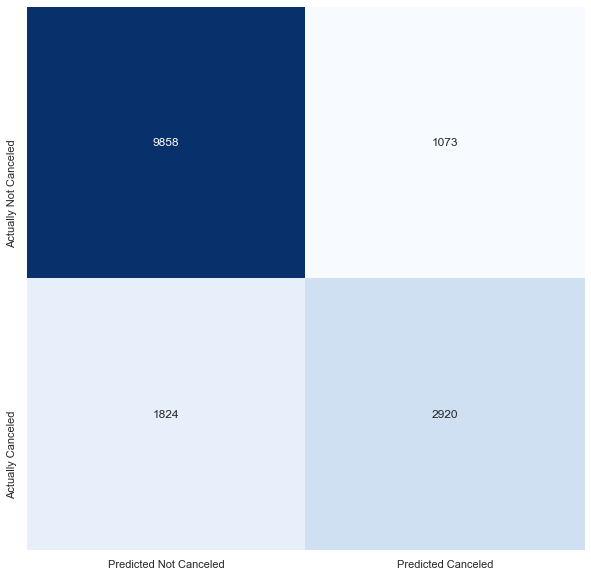

In [104]:
# visualizing the confusion matrix
sns.set(font_scale=1)
plt.figure(figsize=(10,10))
sns.heatmap(GB_matrix,annot=True, fmt="d", cbar=False, cmap="Blues",xticklabels=['Predicted Not Canceled', 'Predicted Canceled'],yticklabels=['Actually Not Canceled', 'Actually Canceled']
            )


In [105]:
# True Positives:
TP = 2920
# True Negatives:
TN = 9858
# False Posititives: 
FP = 1073
# False Negatives: 
FN = 1824
total = 2920+9858+1073+1824

print(f'Correctly classified: {np.round((TP+TN)/total*100)}%')
print(f'Canceled bookings correctly classified: {np.round(TP/(TP+FN)*100)}%')
print(f'Not canceled bookings correctly classified: {np.round(TN/(TN+FP)*100)}%')
print(f'Bookings predicted canceled that are actually canceled: {np.round(TP/(TP+FP)*100)}%')
print(f'Bookings predicted not canceled that are actually not canceled: {np.round(TN/(TN+FN)*100)}%')

Correctly classified: 82.0%
Canceled bookings correctly classified: 62.0%
Not canceled bookings correctly classified: 90.0%
Bookings predicted canceled that are actually canceled: 73.0%
Bookings predicted not canceled that are actually not canceled: 84.0%
